# Sentinel Hub

Notebook for automatically downloading Sentinel2 images from Sentinel Hub.

Documentation:
 - [Process API](https://docs.sentinel-hub.com/api/latest/api/process/)
 - [OGC API](https://www.sentinel-hub.com/develop/api/ogc/)

Webinars and Tutorials on how to use the APIs:
 - [Process API Webinar](https://www.youtube.com/watch?v=sX3w3Wd3FBw)
 - [OGC API Webinar](https://www.youtube.com/watch?v=CBIlTOl2po4)
 - [SentinelHub Python Package GitHub Repository](https://github.com/sentinel-hub/sentinelhub-py/tree/master)
 - [Process API examples notebook](https://github.com/sentinel-hub/sentinelhub-py/blob/master/examples/process_request.ipynb)
 - [OGC API examples notebook](https://github.com/sentinel-hub/sentinelhub-py/blob/master/examples/ogc_request.ipynb)

---
## Credentials

To use Sentinel Hub you need an account and a plan (Exploration plan or free trial is enough for Process API and OGC API). Before using it, you must authenticate using your credentials (client ID and secret). Find more information in the [configuration documentation](https://sentinelhub-py.readthedocs.io/en/latest/configure.html).

On the Sentinel Hub website login with your credentials, then go to your accoun settings. Under OAuth clients click on 'create new', enter a client name and create it. You need to enter the client `secret` in the cell below, as well as the client `ID` which is shown under your newly created client.

In [5]:
from sentinelhub import SHConfig

# Set new credentials:
CLIENT_ID = ""
CLIENT_SECRET = ""

if CLIENT_ID and CLIENT_SECRET:
    # If new credientials are given, update the config file
    config = SHConfig()
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET
    config.save('mar800_profile')
else:
    # Otherwise use the previously saved credentials
    config = SHConfig('mar800_profile')

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

# define instance id
config.instance_id = '0da6e45f-8079-4094-b21a-b8dc99e0fa0f'

In [6]:
config

SHConfig(
  instance_id='********************************fa0f',
  sh_client_id='********************************858a',
  sh_client_secret='************************************ZUBH',
  sh_base_url='https://services.sentinel-hub.com',
  sh_auth_base_url=None,
  sh_token_url='https://services.sentinel-hub.com/oauth/token',
  geopedia_wms_url='https://service.geopedia.world',
  geopedia_rest_url='https://www.geopedia.world/rest',
  aws_access_key_id='',
  aws_secret_access_key='',
  aws_session_token='',
  aws_metadata_url='https://roda.sentinel-hub.com',
  aws_s3_l1c_bucket='sentinel-s2-l1c',
  aws_s3_l2a_bucket='sentinel-s2-l2a',
  opensearch_url='http://opensearch.sentinel-hub.com/resto/api/collections/Sentinel2',
  max_wfs_records_per_query=100,
  max_opensearch_records_per_query=500,
  max_download_attempts=4,
  download_sleep_time=5.0,
  download_timeout_seconds=120.0,
  number_of_download_processes=1,
)

---
## Imports

In [7]:
#%reload_ext autoreload
#%autoreload 2
#%matplotlib inline

In [8]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    WmsRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

---
## Utility functions

In [5]:
def plot_image(
        image: np.ndarray, factor: float = 1.0, clip_range: tuple[float, float] | None = None) -> None:
    """Utility function for plotting RGB images."""
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range))
    else:
        ax.imshow(image * factor)
    ax.set_xticks([])
    ax.set_yticks([])

---

## Defining the area of interest

All requests require a bounding box given as an instance of `sentinelhub.geometry.BBox` with a corresponding Coordinate Reference System CRS (`sentinelhub.constants.CRS`). A bounding box is given by the longitude and latitude of the lower left and upper right corners (see [bboxfinder](http://bboxfinder.com/#0.000000,0.000000,0.000000,0.000000) for easily creating a bounding box).

Here we use WGS84 coordinates (EPSG:4326) for a bounding box coordinates capturing the area of the Maschsee in Hannover, Germany. Afterwards we need to define the spatial resolution in meters, create the bounding box and calculate the size of the output image.

In [42]:
# define the bounding box corner coordinates (lower left, upper right) in WGS84
maschsee_coords_wgs84 = (9.733200, 52.342366, 9.755344, 52.363231)

In [43]:
# define resolution in m
resolution = 10

In [44]:
maschsee_bbox = BBox(bbox=maschsee_coords_wgs84, crs=CRS.WGS84)
maschsee_size = bbox_to_dimensions(maschsee_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {maschsee_size} pixels")

Image shape at 10 m resolution: (148, 234) pixels


---

## Test: Display an Image

We build the request according to the [API Reference](https://docs.sentinel-hub.com/api/latest/reference/), using the SentinelHubRequest class. Each Process API request also needs an [evalscript](https://docs.sentinel-hub.com/api/latest/evalscript/v3/).

The information that we specify in the `SentinelHubRequest` object is:
- an evalscript,
- a list of input data collections with time interval,
- a format of the response,
- a bounding box and it's size (size or resolution).

The evalscript in the example is used to select the appropriate bands. We return the RGB (B04, B03, B02) Sentinel-2 L2A bands.

The image is downloaded with the `ged_data()` method. Without any additional parameters in the evalscript, the downloaded data will correspond to reflectance values in UINT8 format (values in 0-255 range).

In [11]:
# evalscript for a true color image
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

# Request to the Process API
request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=("2018-06-01", "2018-06-30"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=maschsee_bbox,  #
    size=maschsee_size,  # size of the output image we want to retrieve
    config=config,  # configuration defined at the top (Sentinel Hub credentials)
)

In [12]:
# Send the request and download the image
true_color_imgs = request_true_color.get_data()

In [13]:
print(f"Returned data is of type = {type(true_color_imgs)} and length {len(true_color_imgs)}.")
print(f"Single element in the list is of type {type(true_color_imgs[-1])} and has shape {true_color_imgs[-1].shape}")

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (234, 148, 3)


Image type: uint8


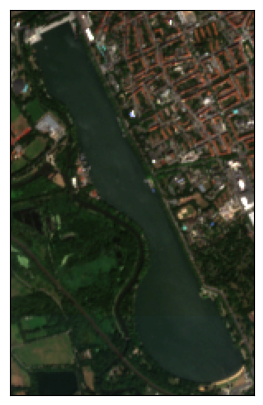

In [14]:
image = true_color_imgs[0]
print(f"Image type: {image.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(image, factor=3.5 / 255, clip_range=(0, 1))

---
## Find dates where images are available (OGC API)

With the Process API we can only ever download one image at a time. So our goal is to first get a list of all dates for which there is an image of the Maschsee available within our desired timeframe. Afterwards we can use these dates to send one request for each date and download the images automatically, one by one.

First, we use a `WmsRequest` with the `get_dates()` method. This will not request any images, but only a list of the dates and times at which an image of the region, defined in the bounding box, was taken.

For that we first need to define an `instance_id` for the `SHConfig`. To retrieve it, go the the _Configuration Utility_ on the dashboard of your account on the Sentinel Hub Website. You can then use the _Simple WMS Template_. If it is not there yet, create it by clicking on _New Configuration_ and select it under _Select from existing instances_. Afterwards, it should be there in the _Configuration Utility_. Now copy the _ID_ into the code cell below:

In [45]:
config.instance_id = '495d1e8d-eb90-4d77-930e-5efd084264c0'

Then we need to select a `data_collection`, i.e. the source of the imagery. For Sentinal2 L2A images, we can use `DataCollection.SENTINEL2_L2A`.

The positional argument `layer` refers to the layer ID in the _Configuration_ for which we provided the `instance_id` above. In the _Configuration Utility_ click on the configuration you chose previously, select one of the layers and copy the _ID_ in here as a string.

For the `bbox` give the `BBox` object we defined before, defining the bounding box of the area of interest, by the longtitude/latitude of the lower left and upper right corners.

Next select a time frame which interests you by giving a start and end date in the format `["yyyy-mm-dd", "yyyy-mm-dd"]`:

In [46]:
time_frame = ["2014-01-01", "2023-11-21"]

`width` is another required argument (or `height`). Here just use the calculated witdth of the bounding box from before.

`time_interval` refers to the time interval in which two or more download requests are considered to be the same.

Lastly, we need to give it the `SHConfig` object with the use credentials to be authorized and the `instance_id` of the configuration we defined previously.

In [47]:
wms_true_color_request_with_deltat = WmsRequest(
    data_collection=DataCollection.SENTINEL2_L2A,
    layer="TRUE-COLOR-S2L2A",
    bbox=maschsee_bbox,
    time=time_frame,
    width=maschsee_size[0],
    image_format=MimeType.TIFF,
    time_difference=datetime.timedelta(hours=0),
    config=config,
)

wms_true_color_img_dates = wms_true_color_request_with_deltat.get_dates()

`wms_true_color_img_dates` now contains a list of `datetime` objects with the timestamps for which there are images available of the region of interest.

In [48]:
print(f'Number of images available: {len(wms_true_color_img_dates)}')

Number of images available: 848


In [56]:
for dt in wms_true_color_img_dates[:5]:
    print(f'{dt.date()}T00:00:00+01:00', f'{dt.date()}T23:59:59+01:00')
    # 2019-01-31T14:00:00+01:00

2016-11-01T00:00:00+01:00 2016-11-01T23:59:59+01:00
2016-11-11T00:00:00+01:00 2016-11-11T23:59:59+01:00
2016-11-21T00:00:00+01:00 2016-11-21T23:59:59+01:00
2016-12-01T00:00:00+01:00 2016-12-01T23:59:59+01:00
2016-12-11T00:00:00+01:00 2016-12-11T23:59:59+01:00


---
## Download all images from timeframe (Process API)

Now we can use the list of `datetime` objects to send a single request for each day using the Process API and download the images one by one.

Since we want to retrieve all bands from the image, we need to specify an `evalscript` to do this. We can download them in 16bit integer `INT16` format as digital numbers `DN`. The resulting images need less storage space and less Sentinel Hub processing units (which are limited per month).

The digital numbers are in the range of 0-10000, so to get reflectances between 0 and 1, we need to scale the downloaded data appropriately later on by dividing each value by 10000.

In [49]:
evalscript_all_bands = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B11","B12"],
                units: "DN"
            }],
            output: {
                bands: 12,
                sampleType: "INT16"
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B01,
                sample.B02,
                sample.B03,
                sample.B04,
                sample.B05,
                sample.B06,
                sample.B07,
                sample.B08,
                sample.B8A,
                sample.B09,
                sample.B11,
                sample.B12];
    }
"""

Now we can define a function that returns a request for a given date. We can use a `SentinelHubRequest`, where we need to specify the above mentioned `evalscript`.

Then we need to specify the input data, which includes the `data_collection`, which again is `DataCollection.SENTINEL2_L2A` for Sentinel2 L2A images, as well as the `time_interval`, for which we plug in the dates of the `datetime` objects later on. `mosaicking_order` can be set to `MosaickingOrder.Least_CC`, which means that, if there were more than one image available for the region for the timeframe, it would return the image with the least cloud coverage.

Under `responses` we define the output datatype that we want to have. Since we have 13 channels, we save it as a `tif` file and set it to `MimeType.TIFF`.

Then we again give the bounding Box (`bbox` as `BBox` object) of our region of interest and output image size (`size`), which we calculated before.

Lastly, we pass the `SHConfig` object to `config` to be authorized:

In [63]:
def get_request_for_all_bands_for_given_date(eval_script,
                                             data_dir,
                                             bbox,
                                             bbox_size,
                                             date,
                                             config,
                                             data_collection=DataCollection.SENTINEL2_L2A,
                                             mime_type=MimeType.TIFF):
    request_all_bands = SentinelHubRequest(
        evalscript=eval_script,
        data_folder=data_dir,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=data_collection,
                time_interval=[f'{date}T00:00:00+01:00', f'{date}T23:59:59+01:00'],
                mosaicking_order=MosaickingOrder.LEAST_CC,
            )
        ],
        responses=[SentinelHubRequest.output_response("default", mime_type)],
        bbox=bbox,
        size=bbox_size,
        config=config,
    )
    return request_all_bands

To send the request we use `get_data()` again and to download it as a `tif` file we set the `save_data` argument to `True`. If we call the function a second time, it will first check if the image is already there before sending another request to download it, which saves us time and Sentinel Hub processing units.

Now we can loop over the `datetime` objects create a request for each one and download the image:

In [64]:
# define a path where to download the images
data_dir = './../data/00_maschsee/00_maschsee_raw'
assert os.path.exists(data_dir), 'Path does not exist'

In [66]:
# Loop over the dates
for dt in wms_true_color_img_dates:
    # convert the datetime object to a string of the date
    dt = str(dt.date())
    img_request = get_request_for_all_bands_for_given_date(eval_script=evalscript_all_bands,
                                                           data_dir=data_dir,
                                                           bbox=maschsee_bbox,
                                                           bbox_size=maschsee_size,
                                                           date=dt,
                                                           config=config,
                                                           data_collection=DataCollection.SENTINEL2_L2A,
                                                           mime_type=MimeType.TIFF)
    all_bands_img = img_request.get_data(save_data=True)

For visualizing the image downloaded last, we can call:

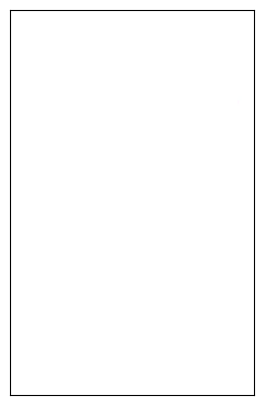

In [36]:
plot_image(all_bands_img[0][:, :, [3, 2, 1]], factor=3.5 / 1e4, clip_range=(0, 1))

### Utilities

In [9]:
def get_bbox_and_size(coords, resolution, crs=CRS.WGS84):
    bbox = BBox(bbox=coords, crs=crs)
    bbox_size = bbox_to_dimensions(bbox, resolution=resolution)
    return bbox, bbox_size


def get_wms_request(bbox, time_frame, width, config, image_format=MimeType.TIFF,
                    time_difference=datetime.timedelta(hours=2), data_collection=DataCollection.SENTINEL2_L2A,
                    layer='TRUE-COLOR-S2L2A'):
    wms_request = WmsRequest(
        data_collection=data_collection,
        layer=layer,
        bbox=bbox,
        time=time_frame,
        width=width,
        image_format=image_format,
        time_difference=time_difference,
        config=config,
    )
    return wms_request


evalscript_all_bands = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B11","B12"],
                units: "DN"
            }],
            output: {
                bands: 12,
                sampleType: "INT16"
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B01,
                sample.B02,
                sample.B03,
                sample.B04,
                sample.B05,
                sample.B06,
                sample.B07,
                sample.B08,
                sample.B8A,
                sample.B09,
                sample.B11,
                sample.B12];
    }
"""


def get_img_request_for_given_date(eval_script,
                                   data_dir,
                                   bbox,
                                   bbox_size,
                                   date,
                                   config,
                                   data_collection=DataCollection.SENTINEL2_L2A,
                                   mime_type=MimeType.TIFF):
    img_request_for_given_date = SentinelHubRequest(
        evalscript=eval_script,
        data_folder=data_dir,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=data_collection,
                time_interval=[f'{date}T00:00:00+01:00', f'{date}T23:59:59+01:00'],
                mosaicking_order=MosaickingOrder.LEAST_CC,
            )
        ],
        responses=[SentinelHubRequest.output_response("default", mime_type)],
        bbox=bbox,
        size=bbox_size,
        config=config,
    )
    return img_request_for_given_date


def download_all_images(data_dir,
                        img_dates,
                        eval_script,
                        bbox,
                        bbox_size,
                        config,
                        data_collection=DataCollection.SENTINEL2_L2A,
                        mime_type=MimeType.TIFF):
    print('Starting image download...')
    # Loop over the dates
    for dt in img_dates:
        # convert the datetime object to a string of the date
        dt = str(dt.date())
        img_request = get_img_request_for_given_date(eval_script=eval_script,
                                                     data_dir=data_dir,
                                                     bbox=bbox,
                                                     bbox_size=bbox_size,
                                                     date=dt,
                                                     config=config,
                                                     data_collection=data_collection,
                                                     mime_type=mime_type)
        all_bands_img = img_request.get_data(save_data=True)
    print('Finished.')


def plot_image(
        image: np.ndarray, factor: float = 1.0, clip_range: tuple[float, float] | None = None) -> None:
    """Utility function for plotting RGB images."""
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range))
    else:
        ax.imshow(image * factor)
    ax.set_xticks([])
    ax.set_yticks([])


def plot_test_image(bbox,
                    size,
                    config,
                    data_collection=DataCollection.SENTINEL2_L2A,
                    time_interval=("2019-06-01", "2023-06-30"),
                    max_cloud_coverage=0.2):
    # evalscript for a true color image
    evalscript_true_color = """
        //VERSION=3

        function setup() {
            return {
                input: [{
                    bands: ["B02", "B03", "B04"]
                }],
                output: {
                    bands: 3
                }
            };
        }

        function evaluatePixel(sample) {
            return [sample.B04, sample.B03, sample.B02];
        }
    """
    # Request to the Process API
    request_true_color = SentinelHubRequest(
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=data_collection,
                time_interval=time_interval,
                maxcc=max_cloud_coverage
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
        bbox=bbox,  #
        size=size,  # size of the output image we want to retrieve
        config=config,  # configuration defined at the top (Sentinel Hub credentials)
    )
    # Send the request and download the image
    true_color_img = request_true_color.get_data()
    print(f"Returned data is of type = {type(true_color_img)} and length {len(true_color_img)}.")
    print(f"Single element in the list is of type {type(true_color_img[-1])} and has shape {true_color_img[-1].shape}")
    image = true_color_img[0]
    print(f"Image type: {image.dtype}")
    # plot function
    # factor 1/255 to scale between 0-1
    # factor 3.5 to increase brightness
    plot_image(image, factor=3.5 / 255, clip_range=(0, 1))
    return image

---
### Download 00 Maschsee (NI)

In [6]:
# define the bounding box corner coordinates (lower left, upper right) in WGS84
coords = (9.733200, 52.342366, 9.755344, 52.363231)

# define resolution in m
resolution = 10

# define timeframe
time_frame = ["2014-01-01", "2023-11-28"]

# define a path where to download the images
data_dir = './../data/00_NI_maschsee/00_NI_maschsee_raw'
assert os.path.exists(data_dir), 'Path does not exist'

In [7]:
# Get bbox and bbox size
bbox, size = get_bbox_and_size(coords=coords, resolution=resolution, crs=CRS.WGS84)
print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 10 m resolution: (148, 234) pixels


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (234, 148, 3)
Image type: uint8


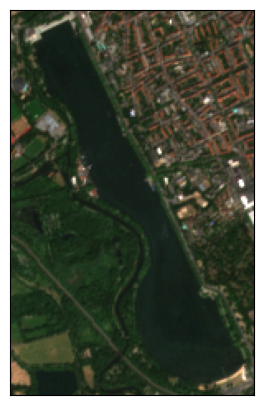

In [8]:
# verify that this is the area of interest
test_img = plot_test_image(bbox=bbox,
                           size=size,
                           config=config,
                           data_collection=DataCollection.SENTINEL2_L2A,
                           time_interval=("2019-06-01", "2023-06-30"),
                           max_cloud_coverage=0.1)

In [9]:
# get the wms request to obtain dates with available images
wms_request = get_wms_request(bbox=bbox,
                              time_frame=time_frame,
                              width=size[0],
                              config=config,
                              image_format=MimeType.TIFF,
                              time_difference=datetime.timedelta(hours=2),
                              data_collection=DataCollection.SENTINEL2_L2A,
                              layer='TRUE-COLOR-S2L2A')
# obtain the dates
img_dates = wms_request.get_dates()

print(f'Number of images available: {len(img_dates)}')
for dt in img_dates[:5]:
    print(f'{dt.date()}T00:00:00+01:00', f'{dt.date()}T23:59:59+01:00')

Number of images available: 481
2016-11-01T00:00:00+01:00 2016-11-01T23:59:59+01:00
2016-11-11T00:00:00+01:00 2016-11-11T23:59:59+01:00
2016-11-21T00:00:00+01:00 2016-11-21T23:59:59+01:00
2016-12-01T00:00:00+01:00 2016-12-01T23:59:59+01:00
2016-12-11T00:00:00+01:00 2016-12-11T23:59:59+01:00


In [10]:
# download all images from time frame
download_all_images(data_dir=data_dir,
                    img_dates=img_dates,
                    eval_script=evalscript_all_bands,
                    bbox=bbox,
                    bbox_size=size,
                    config=config,
                    data_collection=DataCollection.SENTINEL2_L2A,
                    mime_type=MimeType.TIFF)

Starting image download...
Finished.


---
### Download 01 Wangermeer (NI)

In [16]:
# define the bounding box corner coordinates (lower left, upper right) in WGS84
coords = (7.909834,53.664989,7.930133,53.677583)

# define resolution in m
resolution = 10

# define timeframe
time_frame = ["2014-01-01", "2023-11-21"]

# define a path where to download the images
data_dir = './../data/01_NI_wangermeer/01_NI_wangermeer_raw'
assert os.path.exists(data_dir), 'Path does not exist'

In [17]:
# Get bbox and bbox size
bbox, size = get_bbox_and_size(coords=coords, resolution=resolution, crs=CRS.WGS84)
print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 10 m resolution: (136, 138) pixels


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (138, 136, 3)
Image type: uint8


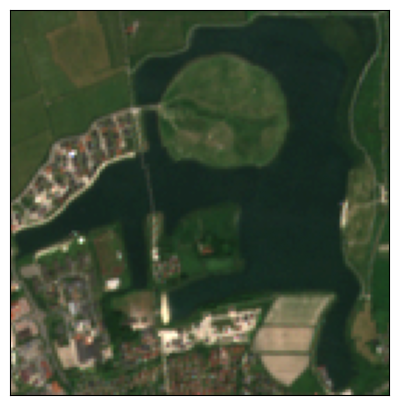

In [18]:
# verify that this is the area of interest
test_img = plot_test_image(bbox=bbox,
                           size=size,
                           config=config,
                           data_collection=DataCollection.SENTINEL2_L2A,
                           time_interval=("2019-06-01", "2023-06-30"),
                           max_cloud_coverage=0.1)

In [19]:
# get the wms request to obtain dates with available images
wms_request = get_wms_request(bbox=bbox,
                              time_frame=time_frame,
                              width=size[0],
                              config=config,
                              image_format=MimeType.TIFF,
                              time_difference=datetime.timedelta(hours=2),
                              data_collection=DataCollection.SENTINEL2_L2A,
                              layer='TRUE-COLOR-S2L2A')
# obtain the dates
img_dates = wms_request.get_dates()

print(f'Number of images available: {len(img_dates)}')
for dt in img_dates[:5]:
    print(f'{dt.date()}T00:00:00+01:00', f'{dt.date()}T23:59:59+01:00')

Number of images available: 479
2016-11-04T00:00:00+01:00 2016-11-04T23:59:59+01:00
2016-11-14T00:00:00+01:00 2016-11-14T23:59:59+01:00
2016-11-24T00:00:00+01:00 2016-11-24T23:59:59+01:00
2016-12-04T00:00:00+01:00 2016-12-04T23:59:59+01:00
2016-12-14T00:00:00+01:00 2016-12-14T23:59:59+01:00


In [20]:
# download all images from time frame
download_all_images(data_dir=data_dir,
                    img_dates=img_dates,
                    eval_script=evalscript_all_bands,
                    bbox=bbox,
                    bbox_size=size,
                    config=config,
                    data_collection=DataCollection.SENTINEL2_L2A,
                    mime_type=MimeType.TIFF)

Starting image download...
Finished.


---

### Download 02: Voerder See (NI)

In [21]:
# define the bounding box corner coordinates (lower left, upper right) in WGS84
coords = (9.147620,53.488227,9.165516,53.497390)

# define resolution in m
resolution = 10

# define timeframe
time_frame = ["2014-01-01", "2023-11-21"]

# define a path where to download the images
data_dir = './../data/02_NI_voerder_see/02_NI_voerder_see_raw'
assert os.path.exists(data_dir), 'Path does not exist'

In [22]:
# Get bbox and bbox size
bbox, size = get_bbox_and_size(coords=coords, resolution=resolution, crs=CRS.WGS84)
print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 10 m resolution: (119, 102) pixels


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (102, 119, 3)
Image type: uint8


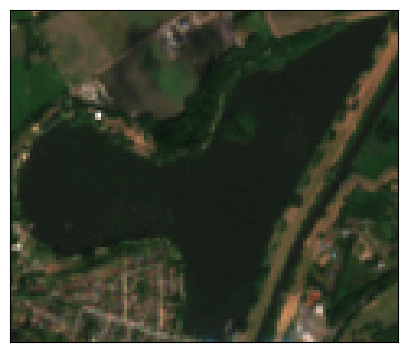

In [23]:
# verify that this is the area of interest
test_img = plot_test_image(bbox=bbox,
                           size=size,
                           config=config,
                           data_collection=DataCollection.SENTINEL2_L2A,
                           time_interval=("2019-06-01", "2023-06-30"),
                           max_cloud_coverage=0.1)

In [25]:
# get the wms request to obtain dates with available images
wms_request = get_wms_request(bbox=bbox,
                              time_frame=time_frame,
                              width=size[0],
                              config=config,
                              image_format=MimeType.TIFF,
                              time_difference=datetime.timedelta(hours=4),
                              data_collection=DataCollection.SENTINEL2_L2A,
                              layer='TRUE-COLOR-S2L2A')
# obtain the dates
img_dates = wms_request.get_dates()

print(f'Number of images available: {len(img_dates)}')
for dt in img_dates[:-5]:
    print(f'{dt.date()}T00:00:00+01:00', f'{dt.date()}T23:59:59+01:00')

Number of images available: 955
2016-11-01T00:00:00+01:00 2016-11-01T23:59:59+01:00
2016-11-04T00:00:00+01:00 2016-11-04T23:59:59+01:00
2016-11-11T00:00:00+01:00 2016-11-11T23:59:59+01:00
2016-11-14T00:00:00+01:00 2016-11-14T23:59:59+01:00
2016-11-21T00:00:00+01:00 2016-11-21T23:59:59+01:00


In [27]:
# download all images from time frame
download_all_images(data_dir=data_dir,
                    img_dates=img_dates,
                    eval_script=evalscript_all_bands,
                    bbox=bbox,
                    bbox_size=size,
                    config=config,
                    data_collection=DataCollection.SENTINEL2_L2A,
                    mime_type=MimeType.TIFF)

Starting image download...
Finished.


---

### Download 03: Salzgitter See (NI)

In [13]:
# define the bounding box corner coordinates (lower left, upper right) in WGS84
coords = (10.297551,52.147104,10.316434,52.165950)

# define resolution in m
resolution = 10

# define timeframe
time_frame = ["2014-01-01", "2023-11-27"]

# define a path where to download the images
data_dir = './../data/03_NI_salzgitter_see/03_NI_salzgitter_see_raw'
assert os.path.exists(data_dir), 'Path does not exist'

In [14]:
# Get bbox and bbox size
bbox, size = get_bbox_and_size(coords=coords, resolution=resolution, crs=CRS.WGS84)
print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 10 m resolution: (125, 212) pixels


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (212, 125, 3)
Image type: uint8


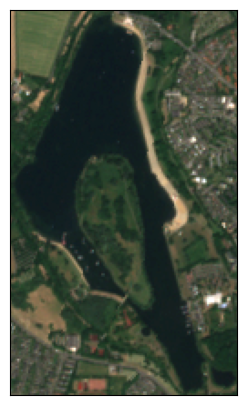

In [15]:
# verify that this is the area of interest
test_img = plot_test_image(bbox=bbox,
                           size=size,
                           config=config,
                           data_collection=DataCollection.SENTINEL2_L2A,
                           time_interval=("2019-06-01", "2023-06-30"),
                           max_cloud_coverage=0.1)

In [17]:
# get the wms request to obtain dates with available images
wms_request = get_wms_request(bbox=bbox,
                              time_frame=time_frame,
                              width=size[0],
                              config=config,
                              image_format=MimeType.TIFF,
                              time_difference=datetime.timedelta(hours=4),
                              data_collection=DataCollection.SENTINEL2_L2A,
                              layer='TRUE-COLOR-S2L2A')
# obtain the dates
img_dates = wms_request.get_dates()

print(f'Number of images available: {len(img_dates)}')
for dt in img_dates[:5]:
    print(f'{dt.date()}T00:00:00+01:00', f'{dt.date()}T23:59:59+01:00')

Number of images available: 956
2016-11-01T00:00:00+01:00 2016-11-01T23:59:59+01:00
2016-11-08T00:00:00+01:00 2016-11-08T23:59:59+01:00
2016-11-11T00:00:00+01:00 2016-11-11T23:59:59+01:00
2016-11-18T00:00:00+01:00 2016-11-18T23:59:59+01:00
2016-11-21T00:00:00+01:00 2016-11-21T23:59:59+01:00


In [18]:
# download all images from time frame
download_all_images(data_dir=data_dir,
                    img_dates=img_dates,
                    eval_script=evalscript_all_bands,
                    bbox=bbox,
                    bbox_size=size,
                    config=config,
                    data_collection=DataCollection.SENTINEL2_L2A,
                    mime_type=MimeType.TIFF)

Starting image download...
Finished.


---

### Download 04: Heerter See (NI)

In [19]:
# define the bounding box corner coordinates (lower left, upper right) in WGS84
coords = (10.370951,52.107730,10.399296,52.120218)

# define resolution in m
resolution = 10

# define timeframe
time_frame = ["2014-01-01", "2023-11-27"]

# define a path where to download the images
data_dir = './../data/04_NI_heerter_see/04_NI_heerter_see_raw'
assert os.path.exists(data_dir), 'Path does not exist'

In [20]:
# Get bbox and bbox size
bbox, size = get_bbox_and_size(coords=coords, resolution=resolution, crs=CRS.WGS84)
print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 10 m resolution: (191, 143) pixels


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (143, 191, 3)
Image type: uint8


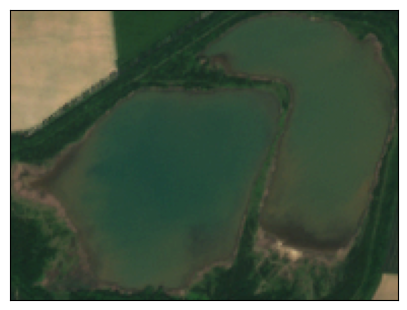

In [21]:
# verify that this is the area of interest
test_img = plot_test_image(bbox=bbox,
                           size=size,
                           config=config,
                           data_collection=DataCollection.SENTINEL2_L2A,
                           time_interval=("2019-06-01", "2023-06-30"),
                           max_cloud_coverage=0.1)

In [22]:
# get the wms request to obtain dates with available images
wms_request = get_wms_request(bbox=bbox,
                              time_frame=time_frame,
                              width=size[0],
                              config=config,
                              image_format=MimeType.TIFF,
                              time_difference=datetime.timedelta(hours=4),
                              data_collection=DataCollection.SENTINEL2_L2A,
                              layer='TRUE-COLOR-S2L2A')
# obtain the dates
img_dates = wms_request.get_dates()

print(f'Number of images available: {len(img_dates)}')
for dt in img_dates[:5]:
    print(f'{dt.date()}T00:00:00+01:00', f'{dt.date()}T23:59:59+01:00')

Number of images available: 956
2016-11-01T00:00:00+01:00 2016-11-01T23:59:59+01:00
2016-11-08T00:00:00+01:00 2016-11-08T23:59:59+01:00
2016-11-11T00:00:00+01:00 2016-11-11T23:59:59+01:00
2016-11-18T00:00:00+01:00 2016-11-18T23:59:59+01:00
2016-11-21T00:00:00+01:00 2016-11-21T23:59:59+01:00


In [23]:
# download all images from time frame
download_all_images(data_dir=data_dir,
                    img_dates=img_dates,
                    eval_script=evalscript_all_bands,
                    bbox=bbox,
                    bbox_size=size,
                    config=config,
                    data_collection=DataCollection.SENTINEL2_L2A,
                    mime_type=MimeType.TIFF)

Starting image download...
Finished.


---

### Download 05: Seeburger See (NI)

In [24]:
# define the bounding box corner coordinates (lower left, upper right) in WGS84
coords = (10.156603,51.559471,10.173125,51.569992)

# define resolution in m
resolution = 10

# define timeframe
time_frame = ["2014-01-01", "2023-11-27"]

# define a path where to download the images
data_dir = './../data/05_NI_seeburger_see/05_NI_seeburger_see_raw'
assert os.path.exists(data_dir), 'Path does not exist'

In [25]:
# Get bbox and bbox size
bbox, size = get_bbox_and_size(coords=coords, resolution=resolution, crs=CRS.WGS84)
print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 10 m resolution: (113, 119) pixels


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (119, 113, 3)
Image type: uint8


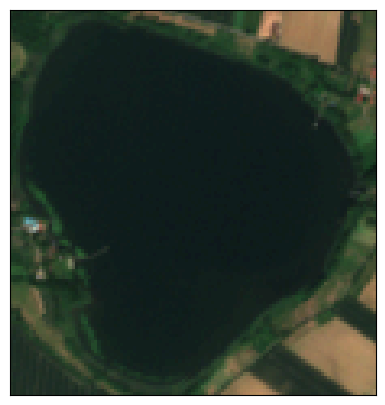

In [26]:
# verify that this is the area of interest
test_img = plot_test_image(bbox=bbox,
                           size=size,
                           config=config,
                           data_collection=DataCollection.SENTINEL2_L2A,
                           time_interval=("2019-06-01", "2023-06-30"),
                           max_cloud_coverage=0.1)

In [27]:
# get the wms request to obtain dates with available images
wms_request = get_wms_request(bbox=bbox,
                              time_frame=time_frame,
                              width=size[0],
                              config=config,
                              image_format=MimeType.TIFF,
                              time_difference=datetime.timedelta(hours=4),
                              data_collection=DataCollection.SENTINEL2_L2A,
                              layer='TRUE-COLOR-S2L2A')
# obtain the dates
img_dates = wms_request.get_dates()

print(f'Number of images available: {len(img_dates)}')
for dt in img_dates[:5]:
    print(f'{dt.date()}T00:00:00+01:00', f'{dt.date()}T23:59:59+01:00')

Number of images available: 956
2016-11-01T00:00:00+01:00 2016-11-01T23:59:59+01:00
2016-11-08T00:00:00+01:00 2016-11-08T23:59:59+01:00
2016-11-11T00:00:00+01:00 2016-11-11T23:59:59+01:00
2016-11-18T00:00:00+01:00 2016-11-18T23:59:59+01:00
2016-11-21T00:00:00+01:00 2016-11-21T23:59:59+01:00


In [28]:
# download all images from time frame
download_all_images(data_dir=data_dir,
                    img_dates=img_dates,
                    eval_script=evalscript_all_bands,
                    bbox=bbox,
                    bbox_size=size,
                    config=config,
                    data_collection=DataCollection.SENTINEL2_L2A,
                    mime_type=MimeType.TIFF)

Starting image download...
Finished.


---

### Download 06: Radener See (MV)

In [36]:
# define the bounding box corner coordinates (lower left, upper right) in WGS84
coords = (12.438111,53.765279,12.458625,53.784350)

# define resolution in m
resolution = 10

# define timeframe
time_frame = ["2014-01-01", "2023-11-28"]

# define a path where to download the images
data_dir = './../data/06_MV_radener_see/06_MV_radener_see_raw'
assert os.path.exists(data_dir), 'Path does not exist'

In [37]:
# Get bbox and bbox size
bbox, size = get_bbox_and_size(coords=coords, resolution=resolution, crs=CRS.WGS84)
print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 10 m resolution: (143, 207) pixels


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (207, 143, 3)
Image type: uint8


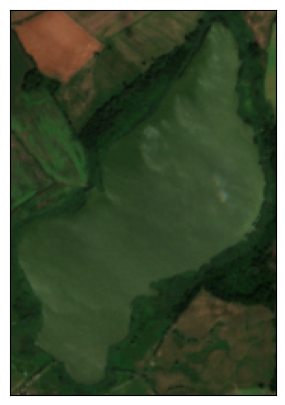

In [38]:
# verify that this is the area of interest
test_img = plot_test_image(bbox=bbox,
                           size=size,
                           config=config,
                           data_collection=DataCollection.SENTINEL2_L2A,
                           time_interval=("2019-06-01", "2023-06-30"),
                           max_cloud_coverage=0.1)

In [39]:
# get the wms request to obtain dates with available images
wms_request = get_wms_request(bbox=bbox,
                              time_frame=time_frame,
                              width=size[0],
                              config=config,
                              image_format=MimeType.TIFF,
                              time_difference=datetime.timedelta(hours=4),
                              data_collection=DataCollection.SENTINEL2_L2A,
                              layer='TRUE-COLOR-S2L2A')
# obtain the dates
img_dates = wms_request.get_dates()

print(f'Number of images available: {len(img_dates)}')
for dt in img_dates[:5]:
    print(f'{dt.date()}T00:00:00+01:00', f'{dt.date()}T23:59:59+01:00')

Number of images available: 961
2016-11-01T00:00:00+01:00 2016-11-01T23:59:59+01:00
2016-11-08T00:00:00+01:00 2016-11-08T23:59:59+01:00
2016-11-11T00:00:00+01:00 2016-11-11T23:59:59+01:00
2016-11-18T00:00:00+01:00 2016-11-18T23:59:59+01:00
2016-11-21T00:00:00+01:00 2016-11-21T23:59:59+01:00


In [40]:
# download all images from time frame
download_all_images(data_dir=data_dir,
                    img_dates=img_dates,
                    eval_script=evalscript_all_bands,
                    bbox=bbox,
                    bbox_size=size,
                    config=config,
                    data_collection=DataCollection.SENTINEL2_L2A,
                    mime_type=MimeType.TIFF)

Starting image download...
Finished.


---

### Download 07: Warinsee (MV)

In [41]:
# define the bounding box corner coordinates (lower left, upper right) in WGS84
coords = (12.373180,53.770098,12.388029,53.789523)

# define resolution in m
resolution = 10

# define timeframe
time_frame = ["2014-01-01", "2023-11-28"]

# define a path where to download the images
data_dir = './../data/07_MV_warinsee/07_MV_warinsee_raw'
assert os.path.exists(data_dir), 'Path does not exist'

In [42]:
# Get bbox and bbox size
bbox, size = get_bbox_and_size(coords=coords, resolution=resolution, crs=CRS.WGS84)
print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 10 m resolution: (106, 212) pixels


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (212, 106, 3)
Image type: uint8


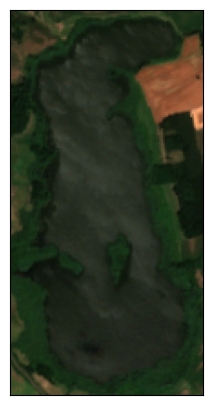

In [43]:
# verify that this is the area of interest
test_img = plot_test_image(bbox=bbox,
                           size=size,
                           config=config,
                           data_collection=DataCollection.SENTINEL2_L2A,
                           time_interval=("2019-06-01", "2023-06-30"),
                           max_cloud_coverage=0.1)

In [44]:
# get the wms request to obtain dates with available images
wms_request = get_wms_request(bbox=bbox,
                              time_frame=time_frame,
                              width=size[0],
                              config=config,
                              image_format=MimeType.TIFF,
                              time_difference=datetime.timedelta(hours=4),
                              data_collection=DataCollection.SENTINEL2_L2A,
                              layer='TRUE-COLOR-S2L2A')
# obtain the dates
img_dates = wms_request.get_dates()

print(f'Number of images available: {len(img_dates)}')
for dt in img_dates[:5]:
    print(f'{dt.date()}T00:00:00+01:00', f'{dt.date()}T23:59:59+01:00')

Number of images available: 961
2016-11-01T00:00:00+01:00 2016-11-01T23:59:59+01:00
2016-11-08T00:00:00+01:00 2016-11-08T23:59:59+01:00
2016-11-11T00:00:00+01:00 2016-11-11T23:59:59+01:00
2016-11-18T00:00:00+01:00 2016-11-18T23:59:59+01:00
2016-11-21T00:00:00+01:00 2016-11-21T23:59:59+01:00


In [45]:
# download all images from time frame
download_all_images(data_dir=data_dir,
                    img_dates=img_dates,
                    eval_script=evalscript_all_bands,
                    bbox=bbox,
                    bbox_size=size,
                    config=config,
                    data_collection=DataCollection.SENTINEL2_L2A,
                    mime_type=MimeType.TIFF)

Starting image download...
Finished.


---

### Download 08: Malkwitzer See (MV)

In [46]:
# define the bounding box corner coordinates (lower left, upper right) in WGS84
coords = (12.429678,53.582863,12.452037,53.592951)

# define resolution in m
resolution = 10

# define timeframe
time_frame = ["2014-01-01", "2023-11-28"]

# define a path where to download the images
data_dir = './../data/08_MV_malkwitzer_see/08_MV_malkwitzer_see_raw'
assert os.path.exists(data_dir), 'Path does not exist'

In [47]:
# Get bbox and bbox size
bbox, size = get_bbox_and_size(coords=coords, resolution=resolution, crs=CRS.WGS84)
print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 10 m resolution: (152, 107) pixels


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (107, 152, 3)
Image type: uint8


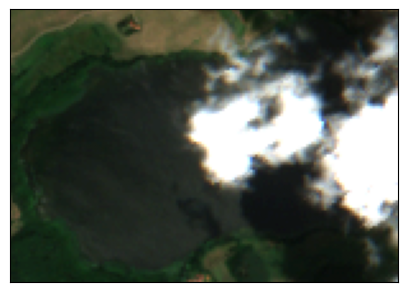

In [48]:
# verify that this is the area of interest
test_img = plot_test_image(bbox=bbox,
                           size=size,
                           config=config,
                           data_collection=DataCollection.SENTINEL2_L2A,
                           time_interval=("2019-06-01", "2023-06-30"),
                           max_cloud_coverage=0.05)

In [49]:
# get the wms request to obtain dates with available images
wms_request = get_wms_request(bbox=bbox,
                              time_frame=time_frame,
                              width=size[0],
                              config=config,
                              image_format=MimeType.TIFF,
                              time_difference=datetime.timedelta(hours=4),
                              data_collection=DataCollection.SENTINEL2_L2A,
                              layer='TRUE-COLOR-S2L2A')
# obtain the dates
img_dates = wms_request.get_dates()

print(f'Number of images available: {len(img_dates)}')
for dt in img_dates[:5]:
    print(f'{dt.date()}T00:00:00+01:00', f'{dt.date()}T23:59:59+01:00')

Number of images available: 961
2016-11-01T00:00:00+01:00 2016-11-01T23:59:59+01:00
2016-11-08T00:00:00+01:00 2016-11-08T23:59:59+01:00
2016-11-11T00:00:00+01:00 2016-11-11T23:59:59+01:00
2016-11-18T00:00:00+01:00 2016-11-18T23:59:59+01:00
2016-11-21T00:00:00+01:00 2016-11-21T23:59:59+01:00


In [50]:
# download all images from time frame
download_all_images(data_dir=data_dir,
                    img_dates=img_dates,
                    eval_script=evalscript_all_bands,
                    bbox=bbox,
                    bbox_size=size,
                    config=config,
                    data_collection=DataCollection.SENTINEL2_L2A,
                    mime_type=MimeType.TIFF)

Starting image download...
Finished.


---

### Download 09: Großuphaler See (MV)

In [51]:
# define the bounding box corner coordinates (lower left, upper right) in WGS84
coords = (12.036552,53.707554,12.061443,53.727211)

# define resolution in m
resolution = 10

# define timeframe
time_frame = ["2014-01-01", "2023-11-28"]

# define a path where to download the images
data_dir = './../data/09_MV_grossuphaler_see/09_MV_grossuphaler_see_raw'
assert os.path.exists(data_dir), 'Path does not exist'

In [52]:
# Get bbox and bbox size
bbox, size = get_bbox_and_size(coords=coords, resolution=resolution, crs=CRS.WGS84)
print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 10 m resolution: (173, 212) pixels


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (212, 173, 3)
Image type: uint8


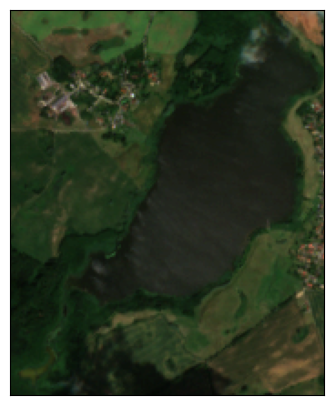

In [53]:
# verify that this is the area of interest
test_img = plot_test_image(bbox=bbox,
                           size=size,
                           config=config,
                           data_collection=DataCollection.SENTINEL2_L2A,
                           time_interval=("2019-06-01", "2023-06-30"),
                           max_cloud_coverage=0.05)

In [54]:
# get the wms request to obtain dates with available images
wms_request = get_wms_request(bbox=bbox,
                              time_frame=time_frame,
                              width=size[0],
                              config=config,
                              image_format=MimeType.TIFF,
                              time_difference=datetime.timedelta(hours=4),
                              data_collection=DataCollection.SENTINEL2_L2A,
                              layer='TRUE-COLOR-S2L2A')
# obtain the dates
img_dates = wms_request.get_dates()

print(f'Number of images available: {len(img_dates)}')
for dt in img_dates[:5]:
    print(f'{dt.date()}T00:00:00+01:00', f'{dt.date()}T23:59:59+01:00')

Number of images available: 963
2016-11-01T00:00:00+01:00 2016-11-01T23:59:59+01:00
2016-11-08T00:00:00+01:00 2016-11-08T23:59:59+01:00
2016-11-11T00:00:00+01:00 2016-11-11T23:59:59+01:00
2016-11-18T00:00:00+01:00 2016-11-18T23:59:59+01:00
2016-11-21T00:00:00+01:00 2016-11-21T23:59:59+01:00


In [55]:
# download all images from time frame
download_all_images(data_dir=data_dir,
                    img_dates=img_dates,
                    eval_script=evalscript_all_bands,
                    bbox=bbox,
                    bbox_size=size,
                    config=config,
                    data_collection=DataCollection.SENTINEL2_L2A,
                    mime_type=MimeType.TIFF)

Starting image download...
Finished.


---

### Download 10: Klein Vielener See (MV)

In [56]:
# define the bounding box corner coordinates (lower left, upper right) in WGS84
coords = (13.035150,53.459438,13.066993,53.469759)

# define resolution in m
resolution = 10

# define timeframe
time_frame = ["2014-01-01", "2023-11-28"]

# define a path where to download the images
data_dir = './../data/10_MV_klein_vielener_see/10_MV_klein_vielener_see_raw'
assert os.path.exists(data_dir), 'Path does not exist'

In [57]:
# Get bbox and bbox size
bbox, size = get_bbox_and_size(coords=coords, resolution=resolution, crs=CRS.WGS84)
print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 10 m resolution: (215, 109) pixels


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (109, 215, 3)
Image type: uint8


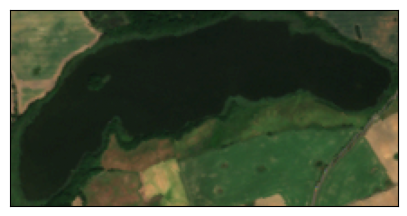

In [58]:
# verify that this is the area of interest
test_img = plot_test_image(bbox=bbox,
                           size=size,
                           config=config,
                           data_collection=DataCollection.SENTINEL2_L2A,
                           time_interval=("2019-06-01", "2023-06-30"),
                           max_cloud_coverage=0.05)

In [59]:
# get the wms request to obtain dates with available images
wms_request = get_wms_request(bbox=bbox,
                              time_frame=time_frame,
                              width=size[0],
                              config=config,
                              image_format=MimeType.TIFF,
                              time_difference=datetime.timedelta(hours=4),
                              data_collection=DataCollection.SENTINEL2_L2A,
                              layer='TRUE-COLOR-S2L2A')
# obtain the dates
img_dates = wms_request.get_dates()

print(f'Number of images available: {len(img_dates)}')
for dt in img_dates[:5]:
    print(f'{dt.date()}T00:00:00+01:00', f'{dt.date()}T23:59:59+01:00')

Number of images available: 958
2016-11-05T00:00:00+01:00 2016-11-05T23:59:59+01:00
2016-11-08T00:00:00+01:00 2016-11-08T23:59:59+01:00
2016-11-15T00:00:00+01:00 2016-11-15T23:59:59+01:00
2016-11-18T00:00:00+01:00 2016-11-18T23:59:59+01:00
2016-11-25T00:00:00+01:00 2016-11-25T23:59:59+01:00


In [60]:
# download all images from time frame
download_all_images(data_dir=data_dir,
                    img_dates=img_dates,
                    eval_script=evalscript_all_bands,
                    bbox=bbox,
                    bbox_size=size,
                    config=config,
                    data_collection=DataCollection.SENTINEL2_L2A,
                    mime_type=MimeType.TIFF)

Starting image download...
Finished.


---

### Download 11: Rühner See (MV)

In [61]:
# define the bounding box corner coordinates (lower left, upper right) in WGS84
coords = (11.930594,53.827737,11.953254,53.839133)

# define resolution in m
resolution = 10

# define timeframe
time_frame = ["2014-01-01", "2023-11-28"]

# define a path where to download the images
data_dir = './../data/11_MV_ruehner_see/11_MV_ruehner_see_raw'
assert os.path.exists(data_dir), 'Path does not exist'

In [62]:
# Get bbox and bbox size
bbox, size = get_bbox_and_size(coords=coords, resolution=resolution, crs=CRS.WGS84)
print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 10 m resolution: (144, 133) pixels


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (133, 144, 3)
Image type: uint8


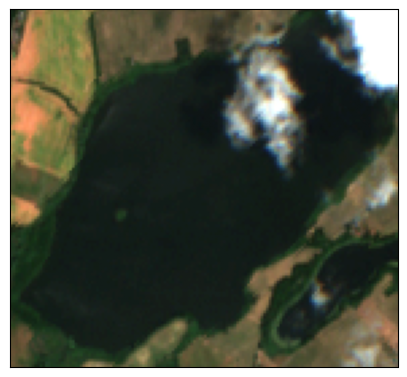

In [63]:
# verify that this is the area of interest
test_img = plot_test_image(bbox=bbox,
                           size=size,
                           config=config,
                           data_collection=DataCollection.SENTINEL2_L2A,
                           time_interval=("2019-06-01", "2023-06-30"),
                           max_cloud_coverage=0.05)

In [64]:
# get the wms request to obtain dates with available images
wms_request = get_wms_request(bbox=bbox,
                              time_frame=time_frame,
                              width=size[0],
                              config=config,
                              image_format=MimeType.TIFF,
                              time_difference=datetime.timedelta(hours=4),
                              data_collection=DataCollection.SENTINEL2_L2A,
                              layer='TRUE-COLOR-S2L2A')
# obtain the dates
img_dates = wms_request.get_dates()

print(f'Number of images available: {len(img_dates)}')
for dt in img_dates[:5]:
    print(f'{dt.date()}T00:00:00+01:00', f'{dt.date()}T23:59:59+01:00')

Number of images available: 958
2016-11-01T00:00:00+01:00 2016-11-01T23:59:59+01:00
2016-11-08T00:00:00+01:00 2016-11-08T23:59:59+01:00
2016-11-11T00:00:00+01:00 2016-11-11T23:59:59+01:00
2016-11-18T00:00:00+01:00 2016-11-18T23:59:59+01:00
2016-11-21T00:00:00+01:00 2016-11-21T23:59:59+01:00


In [65]:
# download all images from time frame
download_all_images(data_dir=data_dir,
                    img_dates=img_dates,
                    eval_script=evalscript_all_bands,
                    bbox=bbox,
                    bbox_size=size,
                    config=config,
                    data_collection=DataCollection.SENTINEL2_L2A,
                    mime_type=MimeType.TIFF)

Starting image download...
Finished.


---

### Download 12: Döpe (MV)

In [11]:
# define the bounding box corner coordinates (lower left, upper right) in WGS84
coords = (11.521697,53.768120,11.539378,53.786328)

# define resolution in m
resolution = 10

# define timeframe
time_frame = ["2014-01-01", "2023-11-28"]

# define a path where to download the images
data_dir = './../data/12_MV_doepe/12_MV_doepe_raw'
assert os.path.exists(data_dir), 'Path does not exist'

In [12]:
# Get bbox and bbox size
bbox, size = get_bbox_and_size(coords=coords, resolution=resolution, crs=CRS.WGS84)
print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 10 m resolution: (109, 207) pixels


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (207, 109, 3)
Image type: uint8


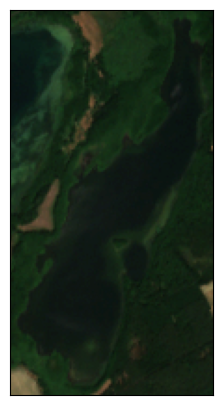

In [13]:
# verify that this is the area of interest
test_img = plot_test_image(bbox=bbox,
                           size=size,
                           config=config,
                           data_collection=DataCollection.SENTINEL2_L2A,
                           time_interval=("2019-06-01", "2023-06-30"),
                           max_cloud_coverage=0.05)

In [14]:
# get the wms request to obtain dates with available images
wms_request = get_wms_request(bbox=bbox,
                              time_frame=time_frame,
                              width=size[0],
                              config=config,
                              image_format=MimeType.TIFF,
                              time_difference=datetime.timedelta(hours=4),
                              data_collection=DataCollection.SENTINEL2_L2A,
                              layer='TRUE-COLOR-S2L2A')
# obtain the dates
img_dates = wms_request.get_dates()

print(f'Number of images available: {len(img_dates)}')
for dt in img_dates[:5]:
    print(f'{dt.date()}T00:00:00+01:00', f'{dt.date()}T23:59:59+01:00')

Number of images available: 958
2016-11-01T00:00:00+01:00 2016-11-01T23:59:59+01:00
2016-11-08T00:00:00+01:00 2016-11-08T23:59:59+01:00
2016-11-11T00:00:00+01:00 2016-11-11T23:59:59+01:00
2016-11-18T00:00:00+01:00 2016-11-18T23:59:59+01:00
2016-11-21T00:00:00+01:00 2016-11-21T23:59:59+01:00


In [15]:
# download all images from time frame
download_all_images(data_dir=data_dir,
                    img_dates=img_dates,
                    eval_script=evalscript_all_bands,
                    bbox=bbox,
                    bbox_size=size,
                    config=config,
                    data_collection=DataCollection.SENTINEL2_L2A,
                    mime_type=MimeType.TIFF)

Starting image download...
Finished.


---

### Download 13: Massower See (MV)

In [16]:
# define the bounding box corner coordinates (lower left, upper right) in WGS84
coords = (12.433348,53.315698,12.449226,53.330617)

# define resolution in m
resolution = 10

# define timeframe
time_frame = ["2014-01-01", "2023-11-28"]

# define a path where to download the images
data_dir = './../data/13_MV_massower_see/13_MV_massower_see_raw'
assert os.path.exists(data_dir), 'Path does not exist'

In [17]:
# Get bbox and bbox size
bbox, size = get_bbox_and_size(coords=coords, resolution=resolution, crs=CRS.WGS84)
print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 10 m resolution: (112, 162) pixels


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (162, 112, 3)
Image type: uint8


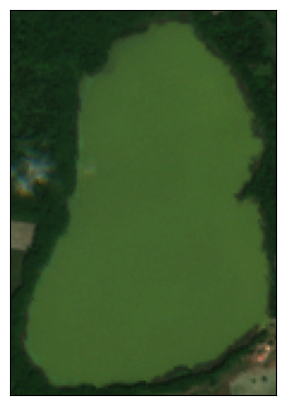

In [18]:
# verify that this is the area of interest
test_img = plot_test_image(bbox=bbox,
                           size=size,
                           config=config,
                           data_collection=DataCollection.SENTINEL2_L2A,
                           time_interval=("2019-06-01", "2023-06-30"),
                           max_cloud_coverage=0.05)

In [19]:
# get the wms request to obtain dates with available images
wms_request = get_wms_request(bbox=bbox,
                              time_frame=time_frame,
                              width=size[0],
                              config=config,
                              image_format=MimeType.TIFF,
                              time_difference=datetime.timedelta(hours=4),
                              data_collection=DataCollection.SENTINEL2_L2A,
                              layer='TRUE-COLOR-S2L2A')
# obtain the dates
img_dates = wms_request.get_dates()

print(f'Number of images available: {len(img_dates)}')
for dt in img_dates[:5]:
    print(f'{dt.date()}T00:00:00+01:00', f'{dt.date()}T23:59:59+01:00')

Number of images available: 706
2016-11-01T00:00:00+01:00 2016-11-01T23:59:59+01:00
2016-11-08T00:00:00+01:00 2016-11-08T23:59:59+01:00
2016-11-18T00:00:00+01:00 2016-11-18T23:59:59+01:00
2016-11-28T00:00:00+01:00 2016-11-28T23:59:59+01:00
2016-12-08T00:00:00+01:00 2016-12-08T23:59:59+01:00


In [20]:
# download all images from time frame
download_all_images(data_dir=data_dir,
                    img_dates=img_dates,
                    eval_script=evalscript_all_bands,
                    bbox=bbox,
                    bbox_size=size,
                    config=config,
                    data_collection=DataCollection.SENTINEL2_L2A,
                    mime_type=MimeType.TIFF)

Starting image download...
Finished.


---

### Download 14: Unterbacher See (NW)

In [40]:
# define the bounding box corner coordinates (lower left, upper right) in WGS84
coords = (6.876347,51.191676,6.909628,51.199274)

# define resolution in m
resolution = 10

# define timeframe
time_frame = ["2014-01-01", "2023-11-28"]

# define a path where to download the images
data_dir = './../data/14_NW_unterbacher_see/14_NW_unterbacher_see_raw'
assert os.path.exists(data_dir), 'Path does not exist'

In [41]:
# Get bbox and bbox size
bbox, size = get_bbox_and_size(coords=coords, resolution=resolution, crs=CRS.WGS84)
print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 10 m resolution: (235, 78) pixels


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (78, 235, 3)
Image type: uint8


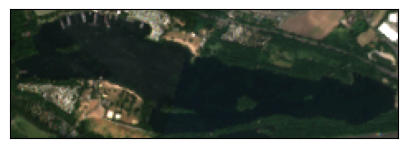

In [42]:
# verify that this is the area of interest
test_img = plot_test_image(bbox=bbox,
                           size=size,
                           config=config,
                           data_collection=DataCollection.SENTINEL2_L2A,
                           time_interval=("2019-06-01", "2023-06-30"),
                           max_cloud_coverage=0.05)

In [43]:
# get the wms request to obtain dates with available images
wms_request = get_wms_request(bbox=bbox,
                              time_frame=time_frame,
                              width=size[0],
                              config=config,
                              image_format=MimeType.TIFF,
                              time_difference=datetime.timedelta(hours=4),
                              data_collection=DataCollection.SENTINEL2_L2A,
                              layer='TRUE-COLOR-S2L2A')
# obtain the dates
img_dates = wms_request.get_dates()

print(f'Number of images available: {len(img_dates)}')
for dt in img_dates[:5]:
    print(f'{dt.date()}T00:00:00+01:00', f'{dt.date()}T23:59:59+01:00')

Number of images available: 960
2016-11-01T00:00:00+01:00 2016-11-01T23:59:59+01:00
2016-11-04T00:00:00+01:00 2016-11-04T23:59:59+01:00
2016-11-11T00:00:00+01:00 2016-11-11T23:59:59+01:00
2016-11-14T00:00:00+01:00 2016-11-14T23:59:59+01:00
2016-11-21T00:00:00+01:00 2016-11-21T23:59:59+01:00


In [44]:
# download all images from time frame
download_all_images(data_dir=data_dir,
                    img_dates=img_dates,
                    eval_script=evalscript_all_bands,
                    bbox=bbox,
                    bbox_size=size,
                    config=config,
                    data_collection=DataCollection.SENTINEL2_L2A,
                    mime_type=MimeType.TIFF)

Starting image download...
Finished.


---

### Download 15: Elfrather See (NW)

In [45]:
# define the bounding box corner coordinates (lower left, upper right) in WGS84
coords = (6.616988,51.376281,6.633554,51.394922)

# define resolution in m
resolution = 10

# define timeframe
time_frame = ["2014-01-01", "2023-11-28"]

# define a path where to download the images
data_dir = './../data/15_NW_elfrather_see/15_NW_elfrather_see_raw'
assert os.path.exists(data_dir), 'Path does not exist'

In [46]:
# Get bbox and bbox size
bbox, size = get_bbox_and_size(coords=coords, resolution=resolution, crs=CRS.WGS84)
print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 10 m resolution: (122, 204) pixels


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (204, 122, 3)
Image type: uint8


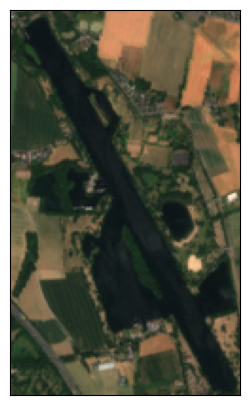

In [47]:
# verify that this is the area of interest
test_img = plot_test_image(bbox=bbox,
                           size=size,
                           config=config,
                           data_collection=DataCollection.SENTINEL2_L2A,
                           time_interval=("2019-06-01", "2023-06-30"),
                           max_cloud_coverage=0.05)

In [48]:
# get the wms request to obtain dates with available images
wms_request = get_wms_request(bbox=bbox,
                              time_frame=time_frame,
                              width=size[0],
                              config=config,
                              image_format=MimeType.TIFF,
                              time_difference=datetime.timedelta(hours=4),
                              data_collection=DataCollection.SENTINEL2_L2A,
                              layer='TRUE-COLOR-S2L2A')
# obtain the dates
img_dates = wms_request.get_dates()

print(f'Number of images available: {len(img_dates)}')
for dt in img_dates[:5]:
    print(f'{dt.date()}T00:00:00+01:00', f'{dt.date()}T23:59:59+01:00')

Number of images available: 483
2016-11-04T00:00:00+01:00 2016-11-04T23:59:59+01:00
2016-11-14T00:00:00+01:00 2016-11-14T23:59:59+01:00
2016-11-24T00:00:00+01:00 2016-11-24T23:59:59+01:00
2016-12-04T00:00:00+01:00 2016-12-04T23:59:59+01:00
2016-12-14T00:00:00+01:00 2016-12-14T23:59:59+01:00


In [49]:
# download all images from time frame
download_all_images(data_dir=data_dir,
                    img_dates=img_dates,
                    eval_script=evalscript_all_bands,
                    bbox=bbox,
                    bbox_size=size,
                    config=config,
                    data_collection=DataCollection.SENTINEL2_L2A,
                    mime_type=MimeType.TIFF)

Starting image download...
Finished.


---

### Download 16: Toeppersee (NW)

In [50]:
# define the bounding box corner coordinates (lower left, upper right) in WGS84
coords = (6.669602,51.396943,6.689601,51.406287)

# define resolution in m
resolution = 10

# define timeframe
time_frame = ["2014-01-01", "2023-11-28"]

# define a path where to download the images
data_dir = './../data/16_NW_toeppersee/16_NW_toeppersee_raw'
assert os.path.exists(data_dir), 'Path does not exist'

In [51]:
# Get bbox and bbox size
bbox, size = get_bbox_and_size(coords=coords, resolution=resolution, crs=CRS.WGS84)
print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 10 m resolution: (142, 99) pixels


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (99, 142, 3)
Image type: uint8


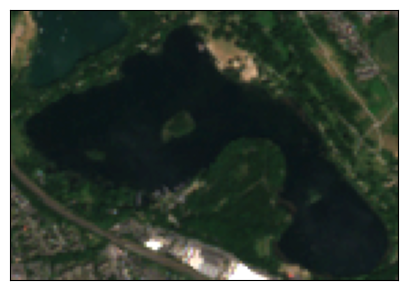

In [52]:
# verify that this is the area of interest
test_img = plot_test_image(bbox=bbox,
                           size=size,
                           config=config,
                           data_collection=DataCollection.SENTINEL2_L2A,
                           time_interval=("2019-06-01", "2023-06-30"),
                           max_cloud_coverage=0.05)

In [53]:
# get the wms request to obtain dates with available images
wms_request = get_wms_request(bbox=bbox,
                              time_frame=time_frame,
                              width=size[0],
                              config=config,
                              image_format=MimeType.TIFF,
                              time_difference=datetime.timedelta(hours=4),
                              data_collection=DataCollection.SENTINEL2_L2A,
                              layer='TRUE-COLOR-S2L2A')
# obtain the dates
img_dates = wms_request.get_dates()

print(f'Number of images available: {len(img_dates)}')
for dt in img_dates[:5]:
    print(f'{dt.date()}T00:00:00+01:00', f'{dt.date()}T23:59:59+01:00')

Number of images available: 483
2016-11-04T00:00:00+01:00 2016-11-04T23:59:59+01:00
2016-11-14T00:00:00+01:00 2016-11-14T23:59:59+01:00
2016-11-24T00:00:00+01:00 2016-11-24T23:59:59+01:00
2016-12-04T00:00:00+01:00 2016-12-04T23:59:59+01:00
2016-12-14T00:00:00+01:00 2016-12-14T23:59:59+01:00


In [54]:
# download all images from time frame
download_all_images(data_dir=data_dir,
                    img_dates=img_dates,
                    eval_script=evalscript_all_bands,
                    bbox=bbox,
                    bbox_size=size,
                    config=config,
                    data_collection=DataCollection.SENTINEL2_L2A,
                    mime_type=MimeType.TIFF)

Starting image download...
Finished.


---

### Download 17: Weserbogen Mittlerer See (MV)

In [55]:
# define the bounding box corner coordinates (lower left, upper right) in WGS84
coords = (8.838351,52.221346,8.863199,52.234410)

# define resolution in m
resolution = 10

# define timeframe
time_frame = ["2014-01-01", "2023-11-28"]

# define a path where to download the images
data_dir = './../data/17_NW_weserbogen_mittlerer_see/17_NW_weserbogen_mittlerer_see_raw'
assert os.path.exists(data_dir), 'Path does not exist'

In [56]:
# Get bbox and bbox size
bbox, size = get_bbox_and_size(coords=coords, resolution=resolution, crs=CRS.WGS84)
print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 10 m resolution: (170, 145) pixels


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (145, 170, 3)
Image type: uint8


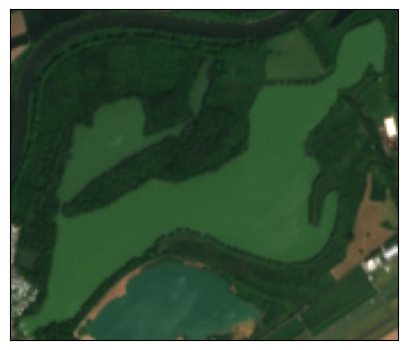

In [57]:
# verify that this is the area of interest
test_img = plot_test_image(bbox=bbox,
                           size=size,
                           config=config,
                           data_collection=DataCollection.SENTINEL2_L2A,
                           time_interval=("2019-06-01", "2023-06-30"),
                           max_cloud_coverage=0.05)

In [58]:
# get the wms request to obtain dates with available images
wms_request = get_wms_request(bbox=bbox,
                              time_frame=time_frame,
                              width=size[0],
                              config=config,
                              image_format=MimeType.TIFF,
                              time_difference=datetime.timedelta(hours=4),
                              data_collection=DataCollection.SENTINEL2_L2A,
                              layer='TRUE-COLOR-S2L2A')
# obtain the dates
img_dates = wms_request.get_dates()

print(f'Number of images available: {len(img_dates)}')
for dt in img_dates[:5]:
    print(f'{dt.date()}T00:00:00+01:00', f'{dt.date()}T23:59:59+01:00')

Number of images available: 960
2016-11-01T00:00:00+01:00 2016-11-01T23:59:59+01:00
2016-11-04T00:00:00+01:00 2016-11-04T23:59:59+01:00
2016-11-11T00:00:00+01:00 2016-11-11T23:59:59+01:00
2016-11-14T00:00:00+01:00 2016-11-14T23:59:59+01:00
2016-11-21T00:00:00+01:00 2016-11-21T23:59:59+01:00


In [59]:
# download all images from time frame
download_all_images(data_dir=data_dir,
                    img_dates=img_dates,
                    eval_script=evalscript_all_bands,
                    bbox=bbox,
                    bbox_size=size,
                    config=config,
                    data_collection=DataCollection.SENTINEL2_L2A,
                    mime_type=MimeType.TIFF)

Starting image download...
Finished.


---

### Download 18: Liblarer See (NW)

In [60]:
# define the bounding box corner coordinates (lower left, upper right) in WGS84
coords = (6.824763,50.813487,6.837895,50.822787)

# define resolution in m
resolution = 10

# define timeframe
time_frame = ["2014-01-01", "2023-11-28"]

# define a path where to download the images
data_dir = './../data/18_NW_liblarer_see/18_NW_liblarer_see_raw'
assert os.path.exists(data_dir), 'Path does not exist'

In [61]:
# Get bbox and bbox size
bbox, size = get_bbox_and_size(coords=coords, resolution=resolution, crs=CRS.WGS84)
print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 10 m resolution: (96, 101) pixels


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (101, 96, 3)
Image type: uint8


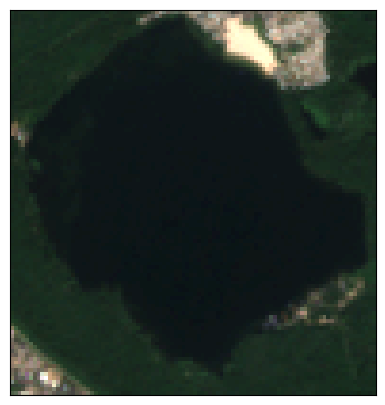

In [62]:
# verify that this is the area of interest
test_img = plot_test_image(bbox=bbox,
                           size=size,
                           config=config,
                           data_collection=DataCollection.SENTINEL2_L2A,
                           time_interval=("2019-06-01", "2023-06-30"),
                           max_cloud_coverage=0.05)

In [63]:
# get the wms request to obtain dates with available images
wms_request = get_wms_request(bbox=bbox,
                              time_frame=time_frame,
                              width=size[0],
                              config=config,
                              image_format=MimeType.TIFF,
                              time_difference=datetime.timedelta(hours=4),
                              data_collection=DataCollection.SENTINEL2_L2A,
                              layer='TRUE-COLOR-S2L2A')
# obtain the dates
img_dates = wms_request.get_dates()

print(f'Number of images available: {len(img_dates)}')
for dt in img_dates[:5]:
    print(f'{dt.date()}T00:00:00+01:00', f'{dt.date()}T23:59:59+01:00')

Number of images available: 962
2016-11-01T00:00:00+01:00 2016-11-01T23:59:59+01:00
2016-11-04T00:00:00+01:00 2016-11-04T23:59:59+01:00
2016-11-11T00:00:00+01:00 2016-11-11T23:59:59+01:00
2016-11-14T00:00:00+01:00 2016-11-14T23:59:59+01:00
2016-11-21T00:00:00+01:00 2016-11-21T23:59:59+01:00


In [64]:
# download all images from time frame
download_all_images(data_dir=data_dir,
                    img_dates=img_dates,
                    eval_script=evalscript_all_bands,
                    bbox=bbox,
                    bbox_size=size,
                    config=config,
                    data_collection=DataCollection.SENTINEL2_L2A,
                    mime_type=MimeType.TIFF)

Starting image download...
Finished.


---

### Download 19: Otto-Maigler-See (MV)

In [65]:
# define the bounding box corner coordinates (lower left, upper right) in WGS84
coords = (6.818390,50.869299,6.845598,50.882297)

# define resolution in m
resolution = 10

# define timeframe
time_frame = ["2014-01-01", "2023-11-28"]

# define a path where to download the images
data_dir = './../data/19_NW_otto_maigler_see/19_NW_otto_maigler_see_raw'
assert os.path.exists(data_dir), 'Path does not exist'

In [66]:
# Get bbox and bbox size
bbox, size = get_bbox_and_size(coords=coords, resolution=resolution, crs=CRS.WGS84)
print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 10 m resolution: (196, 139) pixels


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (139, 196, 3)
Image type: uint8


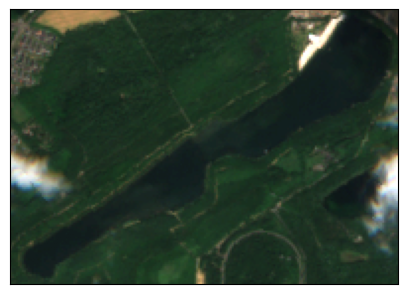

In [67]:
# verify that this is the area of interest
test_img = plot_test_image(bbox=bbox,
                           size=size,
                           config=config,
                           data_collection=DataCollection.SENTINEL2_L2A,
                           time_interval=("2019-06-01", "2023-06-30"),
                           max_cloud_coverage=0.05)

In [68]:
# get the wms request to obtain dates with available images
wms_request = get_wms_request(bbox=bbox,
                              time_frame=time_frame,
                              width=size[0],
                              config=config,
                              image_format=MimeType.TIFF,
                              time_difference=datetime.timedelta(hours=4),
                              data_collection=DataCollection.SENTINEL2_L2A,
                              layer='TRUE-COLOR-S2L2A')
# obtain the dates
img_dates = wms_request.get_dates()

print(f'Number of images available: {len(img_dates)}')
for dt in img_dates[:5]:
    print(f'{dt.date()}T00:00:00+01:00', f'{dt.date()}T23:59:59+01:00')

Number of images available: 962
2016-11-01T00:00:00+01:00 2016-11-01T23:59:59+01:00
2016-11-04T00:00:00+01:00 2016-11-04T23:59:59+01:00
2016-11-11T00:00:00+01:00 2016-11-11T23:59:59+01:00
2016-11-14T00:00:00+01:00 2016-11-14T23:59:59+01:00
2016-11-21T00:00:00+01:00 2016-11-21T23:59:59+01:00


In [69]:
# download all images from time frame
download_all_images(data_dir=data_dir,
                    img_dates=img_dates,
                    eval_script=evalscript_all_bands,
                    bbox=bbox,
                    bbox_size=size,
                    config=config,
                    data_collection=DataCollection.SENTINEL2_L2A,
                    mime_type=MimeType.TIFF)

Starting image download...
Finished.


---

### Download 20: Mözener See (SH)

In [99]:
# define the bounding box corner coordinates (lower left, upper right) in WGS84
coords = (10.233121,53.900394,10.259728,53.920769)

# define resolution in m
resolution = 10

# define timeframe
time_frame = ["2014-01-01", "2023-11-28"]

# define a path where to download the images
data_dir = './../data/20_SH_moezener_see/20_SH_moezener_see_raw'
assert os.path.exists(data_dir), 'Path does not exist'

In [100]:
# Get bbox and bbox size
bbox, size = get_bbox_and_size(coords=coords, resolution=resolution, crs=CRS.WGS84)
print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 10 m resolution: (171, 230) pixels


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (230, 171, 3)
Image type: uint8


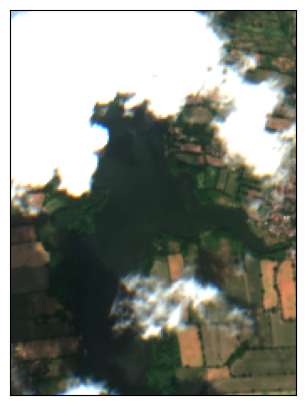

In [101]:
# verify that this is the area of interest
test_img = plot_test_image(bbox=bbox,
                           size=size,
                           config=config,
                           data_collection=DataCollection.SENTINEL2_L2A,
                           time_interval=("2019-06-01", "2023-06-30"),
                           max_cloud_coverage=0.05)

In [102]:
# get the wms request to obtain dates with available images
wms_request = get_wms_request(bbox=bbox,
                              time_frame=time_frame,
                              width=size[0],
                              config=config,
                              image_format=MimeType.TIFF,
                              time_difference=datetime.timedelta(hours=4),
                              data_collection=DataCollection.SENTINEL2_L2A,
                              layer='TRUE-COLOR-S2L2A')
# obtain the dates
img_dates = wms_request.get_dates()

print(f'Number of images available: {len(img_dates)}')
for dt in img_dates[:5]:
    print(f'{dt.date()}T00:00:00+01:00', f'{dt.date()}T23:59:59+01:00')

Number of images available: 948
2016-11-01T00:00:00+01:00 2016-11-01T23:59:59+01:00
2016-11-04T00:00:00+01:00 2016-11-04T23:59:59+01:00
2016-11-11T00:00:00+01:00 2016-11-11T23:59:59+01:00
2016-11-14T00:00:00+01:00 2016-11-14T23:59:59+01:00
2016-11-21T00:00:00+01:00 2016-11-21T23:59:59+01:00


In [103]:
# download all images from time frame
download_all_images(data_dir=data_dir,
                    img_dates=img_dates,
                    eval_script=evalscript_all_bands,
                    bbox=bbox,
                    bbox_size=size,
                    config=config,
                    data_collection=DataCollection.SENTINEL2_L2A,
                    mime_type=MimeType.TIFF)

Starting image download...
Finished.


---

### Download 21: Haddebyer Noor (SH)

In [104]:
# define the bounding box corner coordinates (lower left, upper right) in WGS84
coords = (9.566002,54.485846,9.584026,54.501798)

# define resolution in m
resolution = 10

# define timeframe
time_frame = ["2014-01-01", "2023-11-28"]

# define a path where to download the images
data_dir = './../data/21_SH_haddebyer_noor/21_SH_haddebyer_noor_raw'
assert os.path.exists(data_dir), 'Path does not exist'

In [105]:
# Get bbox and bbox size
bbox, size = get_bbox_and_size(coords=coords, resolution=resolution, crs=CRS.WGS84)
print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 10 m resolution: (115, 178) pixels


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (178, 115, 3)
Image type: uint8


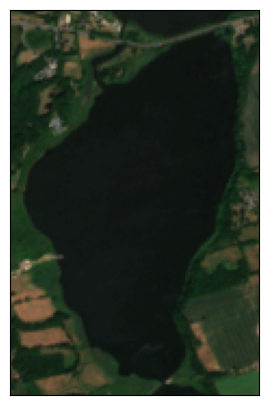

In [106]:
# verify that this is the area of interest
test_img = plot_test_image(bbox=bbox,
                           size=size,
                           config=config,
                           data_collection=DataCollection.SENTINEL2_L2A,
                           time_interval=("2019-06-01", "2023-06-30"),
                           max_cloud_coverage=0.05)

In [107]:
# get the wms request to obtain dates with available images
wms_request = get_wms_request(bbox=bbox,
                              time_frame=time_frame,
                              width=size[0],
                              config=config,
                              image_format=MimeType.TIFF,
                              time_difference=datetime.timedelta(hours=4),
                              data_collection=DataCollection.SENTINEL2_L2A,
                              layer='TRUE-COLOR-S2L2A')
# obtain the dates
img_dates = wms_request.get_dates()

print(f'Number of images available: {len(img_dates)}')
for dt in img_dates[:5]:
    print(f'{dt.date()}T00:00:00+01:00', f'{dt.date()}T23:59:59+01:00')

Number of images available: 967
2016-11-01T00:00:00+01:00 2016-11-01T23:59:59+01:00
2016-11-04T00:00:00+01:00 2016-11-04T23:59:59+01:00
2016-11-11T00:00:00+01:00 2016-11-11T23:59:59+01:00
2016-11-14T00:00:00+01:00 2016-11-14T23:59:59+01:00
2016-11-21T00:00:00+01:00 2016-11-21T23:59:59+01:00


In [108]:
# download all images from time frame
download_all_images(data_dir=data_dir,
                    img_dates=img_dates,
                    eval_script=evalscript_all_bands,
                    bbox=bbox,
                    bbox_size=size,
                    config=config,
                    data_collection=DataCollection.SENTINEL2_L2A,
                    mime_type=MimeType.TIFF)

Starting image download...
Finished.


---

### Download 22: Seedorfer See (SH)

In [109]:
# define the bounding box corner coordinates (lower left, upper right) in WGS84
coords = (10.384526,54.050268,10.424352,54.062612)

# define resolution in m
resolution = 10

# define timeframe
time_frame = ["2014-01-01", "2023-11-28"]

# define a path where to download the images
data_dir = './../data/22_SH_seedorfer_see/22_SH_seedorfer_see_raw'
assert os.path.exists(data_dir), 'Path does not exist'

In [110]:
# Get bbox and bbox size
bbox, size = get_bbox_and_size(coords=coords, resolution=resolution, crs=CRS.WGS84)
print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 10 m resolution: (258, 143) pixels


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (143, 258, 3)
Image type: uint8


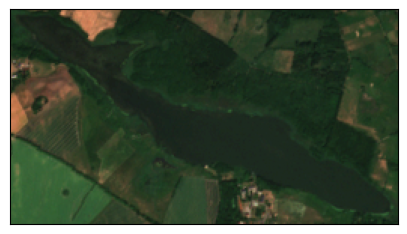

In [111]:
# verify that this is the area of interest
test_img = plot_test_image(bbox=bbox,
                           size=size,
                           config=config,
                           data_collection=DataCollection.SENTINEL2_L2A,
                           time_interval=("2019-06-01", "2023-06-30"),
                           max_cloud_coverage=0.05)

In [112]:
# get the wms request to obtain dates with available images
wms_request = get_wms_request(bbox=bbox,
                              time_frame=time_frame,
                              width=size[0],
                              config=config,
                              image_format=MimeType.TIFF,
                              time_difference=datetime.timedelta(hours=4),
                              data_collection=DataCollection.SENTINEL2_L2A,
                              layer='TRUE-COLOR-S2L2A')
# obtain the dates
img_dates = wms_request.get_dates()

print(f'Number of images available: {len(img_dates)}')
for dt in img_dates[:5]:
    print(f'{dt.date()}T00:00:00+01:00', f'{dt.date()}T23:59:59+01:00')

Number of images available: 486
2016-11-01T00:00:00+01:00 2016-11-01T23:59:59+01:00
2016-11-11T00:00:00+01:00 2016-11-11T23:59:59+01:00
2016-11-21T00:00:00+01:00 2016-11-21T23:59:59+01:00
2016-12-01T00:00:00+01:00 2016-12-01T23:59:59+01:00
2016-12-11T00:00:00+01:00 2016-12-11T23:59:59+01:00


In [114]:
# download all images from time frame
download_all_images(data_dir=data_dir,
                    img_dates=img_dates,
                    eval_script=evalscript_all_bands,
                    bbox=bbox,
                    bbox_size=size,
                    config=config,
                    data_collection=DataCollection.SENTINEL2_L2A,
                    mime_type=MimeType.TIFF)

Starting image download...
Finished.


---

### Download 23: Neversdorfer See (SH)

In [115]:
# define the bounding box corner coordinates (lower left, upper right) in WGS84
coords = (10.258441,53.864929,10.299082,53.873380)

# define resolution in m
resolution = 10

# define timeframe
time_frame = ["2014-01-01", "2023-11-28"]

# define a path where to download the images
data_dir = './../data/23_SH_neversdorfer_see/23_SH_neversdorfer_see_raw'
assert os.path.exists(data_dir), 'Path does not exist'

In [116]:
# Get bbox and bbox size
bbox, size = get_bbox_and_size(coords=coords, resolution=resolution, crs=CRS.WGS84)
print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 10 m resolution: (266, 99) pixels


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (99, 266, 3)
Image type: uint8


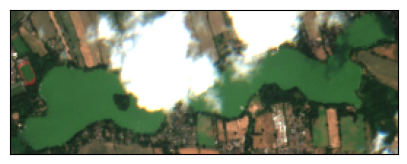

In [117]:
# verify that this is the area of interest
test_img = plot_test_image(bbox=bbox,
                           size=size,
                           config=config,
                           data_collection=DataCollection.SENTINEL2_L2A,
                           time_interval=("2019-06-01", "2023-06-30"),
                           max_cloud_coverage=0.05)

In [118]:
# get the wms request to obtain dates with available images
wms_request = get_wms_request(bbox=bbox,
                              time_frame=time_frame,
                              width=size[0],
                              config=config,
                              image_format=MimeType.TIFF,
                              time_difference=datetime.timedelta(hours=4),
                              data_collection=DataCollection.SENTINEL2_L2A,
                              layer='TRUE-COLOR-S2L2A')
# obtain the dates
img_dates = wms_request.get_dates()

print(f'Number of images available: {len(img_dates)}')
for dt in img_dates[:5]:
    print(f'{dt.date()}T00:00:00+01:00', f'{dt.date()}T23:59:59+01:00')

Number of images available: 480
2016-11-01T00:00:00+01:00 2016-11-01T23:59:59+01:00
2016-11-11T00:00:00+01:00 2016-11-11T23:59:59+01:00
2016-11-21T00:00:00+01:00 2016-11-21T23:59:59+01:00
2016-12-01T00:00:00+01:00 2016-12-01T23:59:59+01:00
2016-12-11T00:00:00+01:00 2016-12-11T23:59:59+01:00


In [119]:
# download all images from time frame
download_all_images(data_dir=data_dir,
                    img_dates=img_dates,
                    eval_script=evalscript_all_bands,
                    bbox=bbox,
                    bbox_size=size,
                    config=config,
                    data_collection=DataCollection.SENTINEL2_L2A,
                    mime_type=MimeType.TIFF)

Starting image download...
Finished.


---

### Download 24: Bordesholmer See (SH)

In [120]:
# define the bounding box corner coordinates (lower left, upper right) in WGS84
coords = (10.008523,54.163929,10.023201,54.177520)

# define resolution in m
resolution = 10

# define timeframe
time_frame = ["2014-01-01", "2023-11-28"]

# define a path where to download the images
data_dir = './../data/24_SH_bordesholmer_see/24_SH_bordesholmer_see_raw'
assert os.path.exists(data_dir), 'Path does not exist'

In [121]:
# Get bbox and bbox size
bbox, size = get_bbox_and_size(coords=coords, resolution=resolution, crs=CRS.WGS84)
print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 10 m resolution: (94, 153) pixels


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (153, 94, 3)
Image type: uint8


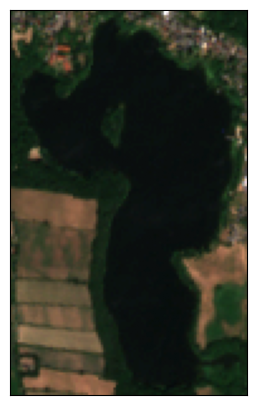

In [122]:
# verify that this is the area of interest
test_img = plot_test_image(bbox=bbox,
                           size=size,
                           config=config,
                           data_collection=DataCollection.SENTINEL2_L2A,
                           time_interval=("2019-06-01", "2023-06-30"),
                           max_cloud_coverage=0.05)

In [123]:
# get the wms request to obtain dates with available images
wms_request = get_wms_request(bbox=bbox,
                              time_frame=time_frame,
                              width=size[0],
                              config=config,
                              image_format=MimeType.TIFF,
                              time_difference=datetime.timedelta(hours=4),
                              data_collection=DataCollection.SENTINEL2_L2A,
                              layer='TRUE-COLOR-S2L2A')
# obtain the dates
img_dates = wms_request.get_dates()

print(f'Number of images available: {len(img_dates)}')
for dt in img_dates[:5]:
    print(f'{dt.date()}T00:00:00+01:00', f'{dt.date()}T23:59:59+01:00')

Number of images available: 967
2016-11-01T00:00:00+01:00 2016-11-01T23:59:59+01:00
2016-11-04T00:00:00+01:00 2016-11-04T23:59:59+01:00
2016-11-11T00:00:00+01:00 2016-11-11T23:59:59+01:00
2016-11-14T00:00:00+01:00 2016-11-14T23:59:59+01:00
2016-11-21T00:00:00+01:00 2016-11-21T23:59:59+01:00


In [124]:
# download all images from time frame
download_all_images(data_dir=data_dir,
                    img_dates=img_dates,
                    eval_script=evalscript_all_bands,
                    bbox=bbox,
                    bbox_size=size,
                    config=config,
                    data_collection=DataCollection.SENTINEL2_L2A,
                    mime_type=MimeType.TIFF)

Starting image download...
Finished.


---

### Download 25: Südensee (SH)

In [125]:
# define the bounding box corner coordinates (lower left, upper right) in WGS84
coords = (9.636662,54.703214,9.668462,54.711768)

# define resolution in m
resolution = 10

# define timeframe
time_frame = ["2014-01-01", "2023-11-28"]

# define a path where to download the images
data_dir = './../data/25_SH_suedensee/25_SH_suedensee_raw'
assert os.path.exists(data_dir), 'Path does not exist'

In [126]:
# Get bbox and bbox size
bbox, size = get_bbox_and_size(coords=coords, resolution=resolution, crs=CRS.WGS84)
print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 10 m resolution: (204, 97) pixels


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (97, 204, 3)
Image type: uint8


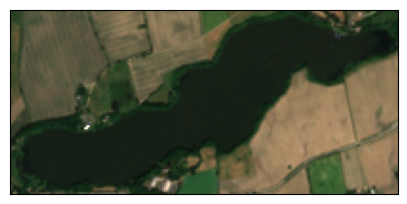

In [127]:
# verify that this is the area of interest
test_img = plot_test_image(bbox=bbox,
                           size=size,
                           config=config,
                           data_collection=DataCollection.SENTINEL2_L2A,
                           time_interval=("2019-06-01", "2023-06-30"),
                           max_cloud_coverage=0.05)

In [128]:
# get the wms request to obtain dates with available images
wms_request = get_wms_request(bbox=bbox,
                              time_frame=time_frame,
                              width=size[0],
                              config=config,
                              image_format=MimeType.TIFF,
                              time_difference=datetime.timedelta(hours=4),
                              data_collection=DataCollection.SENTINEL2_L2A,
                              layer='TRUE-COLOR-S2L2A')
# obtain the dates
img_dates = wms_request.get_dates()

print(f'Number of images available: {len(img_dates)}')
for dt in img_dates[:5]:
    print(f'{dt.date()}T00:00:00+01:00', f'{dt.date()}T23:59:59+01:00')

Number of images available: 967
2016-11-01T00:00:00+01:00 2016-11-01T23:59:59+01:00
2016-11-04T00:00:00+01:00 2016-11-04T23:59:59+01:00
2016-11-11T00:00:00+01:00 2016-11-11T23:59:59+01:00
2016-11-14T00:00:00+01:00 2016-11-14T23:59:59+01:00
2016-11-21T00:00:00+01:00 2016-11-21T23:59:59+01:00


In [129]:
# download all images from time frame
download_all_images(data_dir=data_dir,
                    img_dates=img_dates,
                    eval_script=evalscript_all_bands,
                    bbox=bbox,
                    bbox_size=size,
                    config=config,
                    data_collection=DataCollection.SENTINEL2_L2A,
                    mime_type=MimeType.TIFF)

Starting image download...


KeyboardInterrupt: 

---

### Download 26: Schmalensee (SH)

In [130]:
# define the bounding box corner coordinates (lower left, upper right) in WGS84
coords = (10.237198,54.080692,10.269642,54.090510)

# define resolution in m
resolution = 10

# define timeframe
time_frame = ["2014-01-01", "2023-11-28"]

# define a path where to download the images
data_dir = './../data/26_SH_schmalensee/26_SH_schmalensee_raw'
assert os.path.exists(data_dir), 'Path does not exist'

In [131]:
# Get bbox and bbox size
bbox, size = get_bbox_and_size(coords=coords, resolution=resolution, crs=CRS.WGS84)
print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 10 m resolution: (210, 113) pixels


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (113, 210, 3)
Image type: uint8


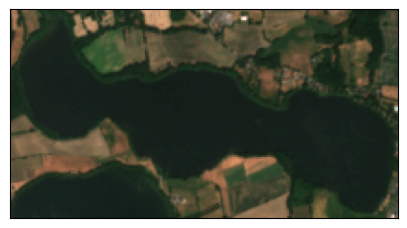

In [132]:
# verify that this is the area of interest
test_img = plot_test_image(bbox=bbox,
                           size=size,
                           config=config,
                           data_collection=DataCollection.SENTINEL2_L2A,
                           time_interval=("2019-06-01", "2023-06-30"),
                           max_cloud_coverage=0.05)

In [133]:
# get the wms request to obtain dates with available images
wms_request = get_wms_request(bbox=bbox,
                              time_frame=time_frame,
                              width=size[0],
                              config=config,
                              image_format=MimeType.TIFF,
                              time_difference=datetime.timedelta(hours=4),
                              data_collection=DataCollection.SENTINEL2_L2A,
                              layer='TRUE-COLOR-S2L2A')
# obtain the dates
img_dates = wms_request.get_dates()

print(f'Number of images available: {len(img_dates)}')
for dt in img_dates[:5]:
    print(f'{dt.date()}T00:00:00+01:00', f'{dt.date()}T23:59:59+01:00')

Number of images available: 969
2016-11-01T00:00:00+01:00 2016-11-01T23:59:59+01:00
2016-11-04T00:00:00+01:00 2016-11-04T23:59:59+01:00
2016-11-11T00:00:00+01:00 2016-11-11T23:59:59+01:00
2016-11-14T00:00:00+01:00 2016-11-14T23:59:59+01:00
2016-11-21T00:00:00+01:00 2016-11-21T23:59:59+01:00


In [134]:
# download all images from time frame
download_all_images(data_dir=data_dir,
                    img_dates=img_dates,
                    eval_script=evalscript_all_bands,
                    bbox=bbox,
                    bbox_size=size,
                    config=config,
                    data_collection=DataCollection.SENTINEL2_L2A,
                    mime_type=MimeType.TIFF)

Starting image download...
Finished.


---

### Download 27: Arenholzer See (SH)

In [135]:
# define the bounding box corner coordinates (lower left, upper right) in WGS84
coords = (9.471846,54.535725,9.493732,54.546181)

# define resolution in m
resolution = 10

# define timeframe
time_frame = ["2014-01-01", "2023-11-28"]

# define a path where to download the images
data_dir = './../data/27_SH_arenholzer_see/27_SH_arenholzer_see_raw'
assert os.path.exists(data_dir), 'Path does not exist'

In [136]:
# Get bbox and bbox size
bbox, size = get_bbox_and_size(coords=coords, resolution=resolution, crs=CRS.WGS84)
print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 10 m resolution: (141, 117) pixels


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (117, 141, 3)
Image type: uint8


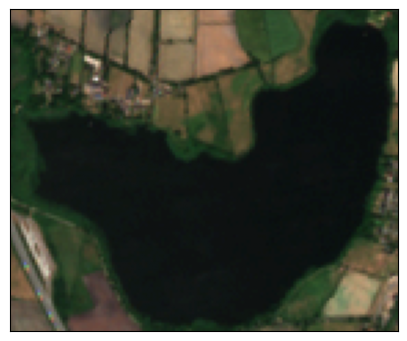

In [137]:
# verify that this is the area of interest
test_img = plot_test_image(bbox=bbox,
                           size=size,
                           config=config,
                           data_collection=DataCollection.SENTINEL2_L2A,
                           time_interval=("2019-06-01", "2023-06-30"),
                           max_cloud_coverage=0.05)

In [138]:
# get the wms request to obtain dates with available images
wms_request = get_wms_request(bbox=bbox,
                              time_frame=time_frame,
                              width=size[0],
                              config=config,
                              image_format=MimeType.TIFF,
                              time_difference=datetime.timedelta(hours=4),
                              data_collection=DataCollection.SENTINEL2_L2A,
                              layer='TRUE-COLOR-S2L2A')
# obtain the dates
img_dates = wms_request.get_dates()

print(f'Number of images available: {len(img_dates)}')
for dt in img_dates[:5]:
    print(f'{dt.date()}T00:00:00+01:00', f'{dt.date()}T23:59:59+01:00')

Number of images available: 967
2016-11-01T00:00:00+01:00 2016-11-01T23:59:59+01:00
2016-11-04T00:00:00+01:00 2016-11-04T23:59:59+01:00
2016-11-11T00:00:00+01:00 2016-11-11T23:59:59+01:00
2016-11-14T00:00:00+01:00 2016-11-14T23:59:59+01:00
2016-11-21T00:00:00+01:00 2016-11-21T23:59:59+01:00


In [139]:
# download all images from time frame
download_all_images(data_dir=data_dir,
                    img_dates=img_dates,
                    eval_script=evalscript_all_bands,
                    bbox=bbox,
                    bbox_size=size,
                    config=config,
                    data_collection=DataCollection.SENTINEL2_L2A,
                    mime_type=MimeType.TIFF)

Starting image download...
Finished.


---

### Download 28: Drüsensee (SH)

In [140]:
# define the bounding box corner coordinates (lower left, upper right) in WGS84
coords = (10.708537,53.581958,10.728707,53.600910)

# define resolution in m
resolution = 10

# define timeframe
time_frame = ["2014-01-01", "2023-11-28"]

# define a path where to download the images
data_dir = './../data/28_SH_druesensee/28_SH_druesensee_raw'
assert os.path.exists(data_dir), 'Path does not exist'

In [141]:
# Get bbox and bbox size
bbox, size = get_bbox_and_size(coords=coords, resolution=resolution, crs=CRS.WGS84)
print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 10 m resolution: (128, 214) pixels


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (214, 128, 3)
Image type: uint8


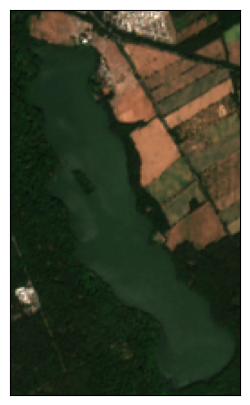

In [142]:
# verify that this is the area of interest
test_img = plot_test_image(bbox=bbox,
                           size=size,
                           config=config,
                           data_collection=DataCollection.SENTINEL2_L2A,
                           time_interval=("2019-06-01", "2023-06-30"),
                           max_cloud_coverage=0.05)

In [143]:
# get the wms request to obtain dates with available images
wms_request = get_wms_request(bbox=bbox,
                              time_frame=time_frame,
                              width=size[0],
                              config=config,
                              image_format=MimeType.TIFF,
                              time_difference=datetime.timedelta(hours=4),
                              data_collection=DataCollection.SENTINEL2_L2A,
                              layer='TRUE-COLOR-S2L2A')
# obtain the dates
img_dates = wms_request.get_dates()

print(f'Number of images available: {len(img_dates)}')
for dt in img_dates[:5]:
    print(f'{dt.date()}T00:00:00+01:00', f'{dt.date()}T23:59:59+01:00')

Number of images available: 958
2016-11-01T00:00:00+01:00 2016-11-01T23:59:59+01:00
2016-11-08T00:00:00+01:00 2016-11-08T23:59:59+01:00
2016-11-11T00:00:00+01:00 2016-11-11T23:59:59+01:00
2016-11-18T00:00:00+01:00 2016-11-18T23:59:59+01:00
2016-11-21T00:00:00+01:00 2016-11-21T23:59:59+01:00


In [144]:
# download all images from time frame
download_all_images(data_dir=data_dir,
                    img_dates=img_dates,
                    eval_script=evalscript_all_bands,
                    bbox=bbox,
                    bbox_size=size,
                    config=config,
                    data_collection=DataCollection.SENTINEL2_L2A,
                    mime_type=MimeType.TIFF)

Starting image download...
Finished.


---

### Download 29: Köthener See (BB)

In [6]:
# define the bounding box corner coordinates (lower left, upper right) in WGS84
coords = (13.786511,52.072358,13.832088,52.084069)

# define resolution in m
resolution = 10

# define timeframe
time_frame = ["2014-01-01", "2023-11-28"]

# define a path where to download the images
data_dir = './../data/29_BB_koethener_see/29_BB_koethener_see_raw'
assert os.path.exists(data_dir), 'Path does not exist'

In [7]:
# Get bbox and bbox size
bbox, size = get_bbox_and_size(coords=coords, resolution=resolution, crs=CRS.WGS84)
print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 10 m resolution: (314, 125) pixels


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (125, 314, 3)
Image type: uint8


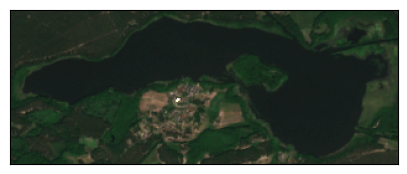

In [8]:
# verify that this is the area of interest
test_img = plot_test_image(bbox=bbox,
                           size=size,
                           config=config,
                           data_collection=DataCollection.SENTINEL2_L2A,
                           time_interval=("2019-06-01", "2023-06-30"),
                           max_cloud_coverage=0.05)

In [9]:
# get the wms request to obtain dates with available images
wms_request = get_wms_request(bbox=bbox,
                              time_frame=time_frame,
                              width=size[0],
                              config=config,
                              image_format=MimeType.TIFF,
                              time_difference=datetime.timedelta(hours=4),
                              data_collection=DataCollection.SENTINEL2_L2A,
                              layer='TRUE-COLOR-S2L2A')
# obtain the dates
img_dates = wms_request.get_dates()

print(f'Number of images available: {len(img_dates)}')
for dt in img_dates[:5]:
    print(f'{dt.date()}T00:00:00+01:00', f'{dt.date()}T23:59:59+01:00')

Number of images available: 952
2016-11-05T00:00:00+01:00 2016-11-05T23:59:59+01:00
2016-11-08T00:00:00+01:00 2016-11-08T23:59:59+01:00
2016-11-15T00:00:00+01:00 2016-11-15T23:59:59+01:00
2016-11-18T00:00:00+01:00 2016-11-18T23:59:59+01:00
2016-11-25T00:00:00+01:00 2016-11-25T23:59:59+01:00


In [10]:
# download all images from time frame
download_all_images(data_dir=data_dir,
                    img_dates=img_dates,
                    eval_script=evalscript_all_bands,
                    bbox=bbox,
                    bbox_size=size,
                    config=config,
                    data_collection=DataCollection.SENTINEL2_L2A,
                    mime_type=MimeType.TIFF)

Starting image download...
Finished.


---

### Download 30: Vielitzsee (BB)

In [16]:
# define the bounding box corner coordinates (lower left, upper right) in WGS84
coords = (12.986355,52.933638,13.029270,52.961772)

# define resolution in m
resolution = 10

# define timeframe
time_frame = ["2014-01-01", "2023-11-28"]

# define a path where to download the images
data_dir = './../data/30_BB_vielitzsee/30_BB_vielitzsee_raw'
assert os.path.exists(data_dir), 'Path does not exist'

In [17]:
# Get bbox and bbox size
bbox, size = get_bbox_and_size(coords=coords, resolution=resolution, crs=CRS.WGS84)
print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 10 m resolution: (297, 305) pixels


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (305, 297, 3)
Image type: uint8


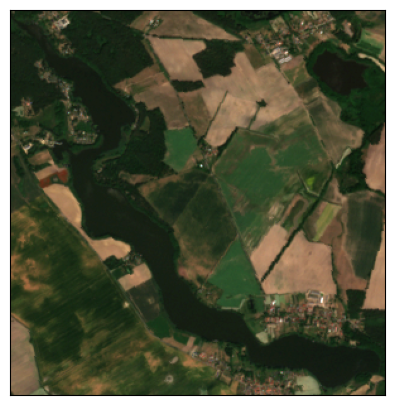

In [18]:
# verify that this is the area of interest
test_img = plot_test_image(bbox=bbox,
                           size=size,
                           config=config,
                           data_collection=DataCollection.SENTINEL2_L2A,
                           time_interval=("2019-06-01", "2023-06-30"),
                           max_cloud_coverage=0.05)

In [19]:
# get the wms request to obtain dates with available images
wms_request = get_wms_request(bbox=bbox,
                              time_frame=time_frame,
                              width=size[0],
                              config=config,
                              image_format=MimeType.TIFF,
                              time_difference=datetime.timedelta(hours=4),
                              data_collection=DataCollection.SENTINEL2_L2A,
                              layer='TRUE-COLOR-S2L2A')
# obtain the dates
img_dates = wms_request.get_dates()

print(f'Number of images available: {len(img_dates)}')
for dt in img_dates[:5]:
    print(f'{dt.date()}T00:00:00+01:00', f'{dt.date()}T23:59:59+01:00')

Number of images available: 959
2016-11-05T00:00:00+01:00 2016-11-05T23:59:59+01:00
2016-11-08T00:00:00+01:00 2016-11-08T23:59:59+01:00
2016-11-15T00:00:00+01:00 2016-11-15T23:59:59+01:00
2016-11-18T00:00:00+01:00 2016-11-18T23:59:59+01:00
2016-11-25T00:00:00+01:00 2016-11-25T23:59:59+01:00


In [20]:
# download all images from time frame
download_all_images(data_dir=data_dir,
                    img_dates=img_dates,
                    eval_script=evalscript_all_bands,
                    bbox=bbox,
                    bbox_size=size,
                    config=config,
                    data_collection=DataCollection.SENTINEL2_L2A,
                    mime_type=MimeType.TIFF)

Starting image download...
Finished.


---

### Download 31: Groß Leuthener See (BB)

In [21]:
# define the bounding box corner coordinates (lower left, upper right) in WGS84
coords = (14.037244,52.034660,14.065912,52.046750)

# define resolution in m
resolution = 10

# define timeframe
time_frame = ["2014-01-01", "2023-11-28"]

# define a path where to download the images
data_dir = './../data/31_BB_gross_leuthener_see/31_BB_gross_leuthener_see_raw'
assert os.path.exists(data_dir), 'Path does not exist'

In [22]:
# Get bbox and bbox size
bbox, size = get_bbox_and_size(coords=coords, resolution=resolution, crs=CRS.WGS84)
print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 10 m resolution: (198, 132) pixels


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (132, 198, 3)
Image type: uint8


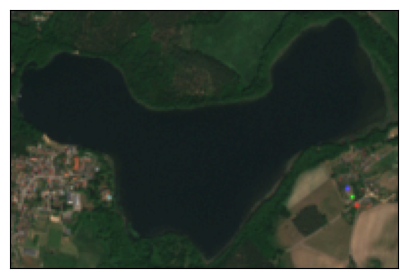

In [23]:
# verify that this is the area of interest
test_img = plot_test_image(bbox=bbox,
                           size=size,
                           config=config,
                           data_collection=DataCollection.SENTINEL2_L2A,
                           time_interval=("2019-06-01", "2023-06-30"),
                           max_cloud_coverage=0.05)

In [24]:
# get the wms request to obtain dates with available images
wms_request = get_wms_request(bbox=bbox,
                              time_frame=time_frame,
                              width=size[0],
                              config=config,
                              image_format=MimeType.TIFF,
                              time_difference=datetime.timedelta(hours=4),
                              data_collection=DataCollection.SENTINEL2_L2A,
                              layer='TRUE-COLOR-S2L2A')
# obtain the dates
img_dates = wms_request.get_dates()

print(f'Number of images available: {len(img_dates)}')
for dt in img_dates[:5]:
    print(f'{dt.date()}T00:00:00+01:00', f'{dt.date()}T23:59:59+01:00')

Number of images available: 952
2016-11-05T00:00:00+01:00 2016-11-05T23:59:59+01:00
2016-11-08T00:00:00+01:00 2016-11-08T23:59:59+01:00
2016-11-15T00:00:00+01:00 2016-11-15T23:59:59+01:00
2016-11-18T00:00:00+01:00 2016-11-18T23:59:59+01:00
2016-11-25T00:00:00+01:00 2016-11-25T23:59:59+01:00


In [25]:
# download all images from time frame
download_all_images(data_dir=data_dir,
                    img_dates=img_dates,
                    eval_script=evalscript_all_bands,
                    bbox=bbox,
                    bbox_size=size,
                    config=config,
                    data_collection=DataCollection.SENTINEL2_L2A,
                    mime_type=MimeType.TIFF)

Starting image download...
Finished.


---

### Download 32: Thymensee (BB)

In [26]:
# define the bounding box corner coordinates (lower left, upper right) in WGS84
coords = (13.136387,53.207935,13.172436,53.227053)

# define resolution in m
resolution = 10

# define timeframe
time_frame = ["2014-01-01", "2023-11-28"]

# define a path where to download the images
data_dir = './../data/32_BB_thymensee/32_BB_thymensee_raw'
assert os.path.exists(data_dir), 'Path does not exist'

In [27]:
# Get bbox and bbox size
bbox, size = get_bbox_and_size(coords=coords, resolution=resolution, crs=CRS.WGS84)
print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 10 m resolution: (246, 206) pixels


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (206, 246, 3)
Image type: uint8


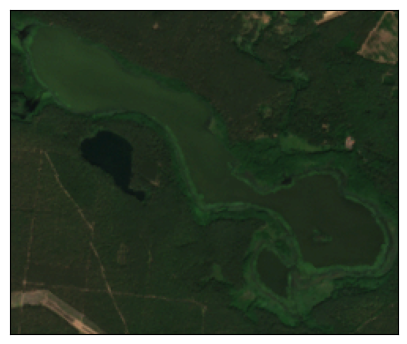

In [28]:
# verify that this is the area of interest
test_img = plot_test_image(bbox=bbox,
                           size=size,
                           config=config,
                           data_collection=DataCollection.SENTINEL2_L2A,
                           time_interval=("2019-06-01", "2023-06-30"),
                           max_cloud_coverage=0.05)

In [29]:
# get the wms request to obtain dates with available images
wms_request = get_wms_request(bbox=bbox,
                              time_frame=time_frame,
                              width=size[0],
                              config=config,
                              image_format=MimeType.TIFF,
                              time_difference=datetime.timedelta(hours=4),
                              data_collection=DataCollection.SENTINEL2_L2A,
                              layer='TRUE-COLOR-S2L2A')
# obtain the dates
img_dates = wms_request.get_dates()

print(f'Number of images available: {len(img_dates)}')
for dt in img_dates[:5]:
    print(f'{dt.date()}T00:00:00+01:00', f'{dt.date()}T23:59:59+01:00')

Number of images available: 962
2016-11-05T00:00:00+01:00 2016-11-05T23:59:59+01:00
2016-11-08T00:00:00+01:00 2016-11-08T23:59:59+01:00
2016-11-15T00:00:00+01:00 2016-11-15T23:59:59+01:00
2016-11-18T00:00:00+01:00 2016-11-18T23:59:59+01:00
2016-11-25T00:00:00+01:00 2016-11-25T23:59:59+01:00


In [30]:
# download all images from time frame
download_all_images(data_dir=data_dir,
                    img_dates=img_dates,
                    eval_script=evalscript_all_bands,
                    bbox=bbox,
                    bbox_size=size,
                    config=config,
                    data_collection=DataCollection.SENTINEL2_L2A,
                    mime_type=MimeType.TIFF)

Starting image download...
Finished.


---

### Download 33: Grössinsee (BB)

In [31]:
# define the bounding box corner coordinates (lower left, upper right) in WGS84
coords = (13.120079,52.247668,13.139305,52.263535)

# define resolution in m
resolution = 10

# define timeframe
time_frame = ["2014-01-01", "2023-11-28"]

# define a path where to download the images
data_dir = './../data/33_BB_groessinsee/33_BB_groessinsee_raw'
assert os.path.exists(data_dir), 'Path does not exist'

In [32]:
# Get bbox and bbox size
bbox, size = get_bbox_and_size(coords=coords, resolution=resolution, crs=CRS.WGS84)
print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 10 m resolution: (136, 173) pixels


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (173, 136, 3)
Image type: uint8


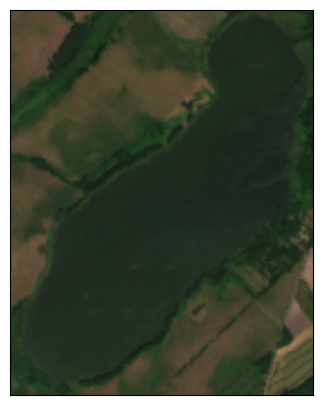

In [33]:
# verify that this is the area of interest
test_img = plot_test_image(bbox=bbox,
                           size=size,
                           config=config,
                           data_collection=DataCollection.SENTINEL2_L2A,
                           time_interval=("2019-06-01", "2023-06-30"),
                           max_cloud_coverage=0.05)

In [34]:
# get the wms request to obtain dates with available images
wms_request = get_wms_request(bbox=bbox,
                              time_frame=time_frame,
                              width=size[0],
                              config=config,
                              image_format=MimeType.TIFF,
                              time_difference=datetime.timedelta(hours=4),
                              data_collection=DataCollection.SENTINEL2_L2A,
                              layer='TRUE-COLOR-S2L2A')
# obtain the dates
img_dates = wms_request.get_dates()

print(f'Number of images available: {len(img_dates)}')
for dt in img_dates[:5]:
    print(f'{dt.date()}T00:00:00+01:00', f'{dt.date()}T23:59:59+01:00')

Number of images available: 966
2016-11-05T00:00:00+01:00 2016-11-05T23:59:59+01:00
2016-11-08T00:00:00+01:00 2016-11-08T23:59:59+01:00
2016-11-15T00:00:00+01:00 2016-11-15T23:59:59+01:00
2016-11-18T00:00:00+01:00 2016-11-18T23:59:59+01:00
2016-11-25T00:00:00+01:00 2016-11-25T23:59:59+01:00


In [35]:
# download all images from time frame
download_all_images(data_dir=data_dir,
                    img_dates=img_dates,
                    eval_script=evalscript_all_bands,
                    bbox=bbox,
                    bbox_size=size,
                    config=config,
                    data_collection=DataCollection.SENTINEL2_L2A,
                    mime_type=MimeType.TIFF)

Starting image download...
Finished.


---

### Download 34: Oelsener See (BB)

In [36]:
# define the bounding box corner coordinates (lower left, upper right) in WGS84
coords = (14.379215,52.125637,14.411659,52.148553)

# define resolution in m
resolution = 10

# define timeframe
time_frame = ["2014-01-01", "2023-11-28"]

# define a path where to download the images
data_dir = './../data/34_BB_oelsener_see/34_BB_oelsener_see_raw'
assert os.path.exists(data_dir), 'Path does not exist'

In [37]:
# Get bbox and bbox size
bbox, size = get_bbox_and_size(coords=coords, resolution=resolution, crs=CRS.WGS84)
print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 10 m resolution: (224, 253) pixels


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (253, 224, 3)
Image type: uint8


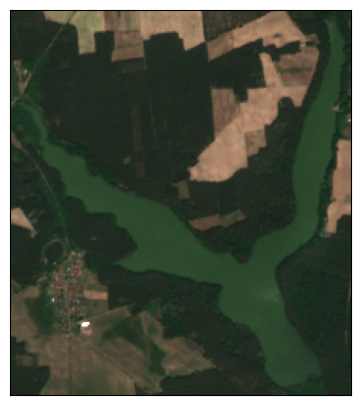

In [38]:
# verify that this is the area of interest
test_img = plot_test_image(bbox=bbox,
                           size=size,
                           config=config,
                           data_collection=DataCollection.SENTINEL2_L2A,
                           time_interval=("2019-06-01", "2023-06-30"),
                           max_cloud_coverage=0.05)

In [39]:
# get the wms request to obtain dates with available images
wms_request = get_wms_request(bbox=bbox,
                              time_frame=time_frame,
                              width=size[0],
                              config=config,
                              image_format=MimeType.TIFF,
                              time_difference=datetime.timedelta(hours=4),
                              data_collection=DataCollection.SENTINEL2_L2A,
                              layer='TRUE-COLOR-S2L2A')
# obtain the dates
img_dates = wms_request.get_dates()

print(f'Number of images available: {len(img_dates)}')
for dt in img_dates[:5]:
    print(f'{dt.date()}T00:00:00+01:00', f'{dt.date()}T23:59:59+01:00')

Number of images available: 476
2016-11-05T00:00:00+01:00 2016-11-05T23:59:59+01:00
2016-11-15T00:00:00+01:00 2016-11-15T23:59:59+01:00
2016-11-25T00:00:00+01:00 2016-11-25T23:59:59+01:00
2016-12-05T00:00:00+01:00 2016-12-05T23:59:59+01:00
2016-12-15T00:00:00+01:00 2016-12-15T23:59:59+01:00


In [40]:
# download all images from time frame
download_all_images(data_dir=data_dir,
                    img_dates=img_dates,
                    eval_script=evalscript_all_bands,
                    bbox=bbox,
                    bbox_size=size,
                    config=config,
                    data_collection=DataCollection.SENTINEL2_L2A,
                    mime_type=MimeType.TIFF)

Starting image download...
Finished.


---

### Download 35: Großer Treppelsee (BB)

In [41]:
# define the bounding box corner coordinates (lower left, upper right) in WGS84
coords = (14.447279,52.133725,14.458523,52.155531)

# define resolution in m
resolution = 10

# define timeframe
time_frame = ["2014-01-01", "2023-11-28"]

# define a path where to download the images
data_dir = './../data/35_BB_grosser_treppelsee/35_BB_grosser_treppelsee_raw'
assert os.path.exists(data_dir), 'Path does not exist'

In [42]:
# Get bbox and bbox size
bbox, size = get_bbox_and_size(coords=coords, resolution=resolution, crs=CRS.WGS84)
print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 10 m resolution: (79, 242) pixels


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (242, 79, 3)
Image type: uint8


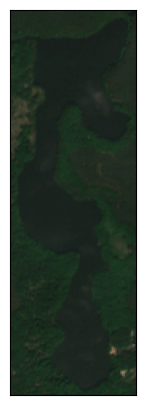

In [43]:
# verify that this is the area of interest
test_img = plot_test_image(bbox=bbox,
                           size=size,
                           config=config,
                           data_collection=DataCollection.SENTINEL2_L2A,
                           time_interval=("2019-06-01", "2023-06-30"),
                           max_cloud_coverage=0.05)

In [44]:
# get the wms request to obtain dates with available images
wms_request = get_wms_request(bbox=bbox,
                              time_frame=time_frame,
                              width=size[0],
                              config=config,
                              image_format=MimeType.TIFF,
                              time_difference=datetime.timedelta(hours=4),
                              data_collection=DataCollection.SENTINEL2_L2A,
                              layer='TRUE-COLOR-S2L2A')
# obtain the dates
img_dates = wms_request.get_dates()

print(f'Number of images available: {len(img_dates)}')
for dt in img_dates[:5]:
    print(f'{dt.date()}T00:00:00+01:00', f'{dt.date()}T23:59:59+01:00')

Number of images available: 476
2016-11-05T00:00:00+01:00 2016-11-05T23:59:59+01:00
2016-11-15T00:00:00+01:00 2016-11-15T23:59:59+01:00
2016-11-25T00:00:00+01:00 2016-11-25T23:59:59+01:00
2016-12-05T00:00:00+01:00 2016-12-05T23:59:59+01:00
2016-12-15T00:00:00+01:00 2016-12-15T23:59:59+01:00


In [45]:
# download all images from time frame
download_all_images(data_dir=data_dir,
                    img_dates=img_dates,
                    eval_script=evalscript_all_bands,
                    bbox=bbox,
                    bbox_size=size,
                    config=config,
                    data_collection=DataCollection.SENTINEL2_L2A,
                    mime_type=MimeType.TIFF)

Starting image download...
Finished.


---

### Download 36: Rohrsee (BW)

In [10]:
# define the bounding box corner coordinates (lower left, upper right) in WGS84
coords = (9.829309,47.869625,9.845231,47.877944)

# define resolution in m
resolution = 10

# define timeframe
time_frame = ["2014-01-01", "2023-11-28"]

# define a path where to download the images
data_dir = './../data/36_BW_rohrsee/36_BW_rohrsee_raw'
assert os.path.exists(data_dir), 'Path does not exist'

In [11]:
# Get bbox and bbox size
bbox, size = get_bbox_and_size(coords=coords, resolution=resolution, crs=CRS.WGS84)
print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 10 m resolution: (118, 94) pixels


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (94, 118, 3)
Image type: uint8


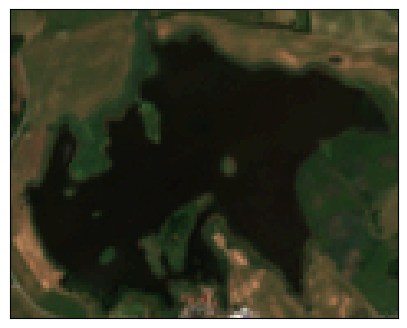

In [12]:
# verify that this is the area of interest
test_img = plot_test_image(bbox=bbox,
                           size=size,
                           config=config,
                           data_collection=DataCollection.SENTINEL2_L2A,
                           time_interval=("2019-06-01", "2023-06-30"),
                           max_cloud_coverage=0.05)

In [13]:
# get the wms request to obtain dates with available images
wms_request = get_wms_request(bbox=bbox,
                              time_frame=time_frame,
                              width=size[0],
                              config=config,
                              image_format=MimeType.TIFF,
                              time_difference=datetime.timedelta(hours=4),
                              data_collection=DataCollection.SENTINEL2_L2A,
                              layer='TRUE-COLOR-S2L2A')
# obtain the dates
img_dates = wms_request.get_dates()

print(f'Number of images available: {len(img_dates)}')
for dt in img_dates[:5]:
    print(f'{dt.date()}T00:00:00+01:00', f'{dt.date()}T23:59:59+01:00')

Number of images available: 477
2016-11-08T00:00:00+01:00 2016-11-08T23:59:59+01:00
2016-11-18T00:00:00+01:00 2016-11-18T23:59:59+01:00
2016-11-28T00:00:00+01:00 2016-11-28T23:59:59+01:00
2016-12-08T00:00:00+01:00 2016-12-08T23:59:59+01:00
2016-12-18T00:00:00+01:00 2016-12-18T23:59:59+01:00


In [14]:
# download all images from time frame
download_all_images(data_dir=data_dir,
                    img_dates=img_dates,
                    eval_script=evalscript_all_bands,
                    bbox=bbox,
                    bbox_size=size,
                    config=config,
                    data_collection=DataCollection.SENTINEL2_L2A,
                    mime_type=MimeType.TIFF)

Starting image download...
Finished.


---

### Download 37: Rattmannsdorfer See (ST)

In [15]:
# define the bounding box corner coordinates (lower left, upper right) in WGS84
coords = (11.932740,51.405738,11.949391,51.417007)

# define resolution in m
resolution = 10

# define timeframe
time_frame = ["2014-01-01", "2023-11-28"]

# define a path where to download the images
data_dir = './../data/37_ST_rattmannsdorfer_see/37_ST_rattmannsdorfer_see_raw'
assert os.path.exists(data_dir), 'Path does not exist'

In [16]:
# Get bbox and bbox size
bbox, size = get_bbox_and_size(coords=coords, resolution=resolution, crs=CRS.WGS84)
print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 10 m resolution: (111, 130) pixels


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (130, 111, 3)
Image type: uint8


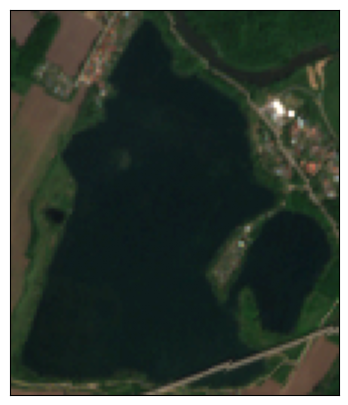

In [17]:
# verify that this is the area of interest
test_img = plot_test_image(bbox=bbox,
                           size=size,
                           config=config,
                           data_collection=DataCollection.SENTINEL2_L2A,
                           time_interval=("2019-06-01", "2023-06-30"),
                           max_cloud_coverage=0.05)

In [18]:
# get the wms request to obtain dates with available images
wms_request = get_wms_request(bbox=bbox,
                              time_frame=time_frame,
                              width=size[0],
                              config=config,
                              image_format=MimeType.TIFF,
                              time_difference=datetime.timedelta(hours=4),
                              data_collection=DataCollection.SENTINEL2_L2A,
                              layer='TRUE-COLOR-S2L2A')
# obtain the dates
img_dates = wms_request.get_dates()

print(f'Number of images available: {len(img_dates)}')
for dt in img_dates[:5]:
    print(f'{dt.date()}T00:00:00+01:00', f'{dt.date()}T23:59:59+01:00')

Number of images available: 480
2016-11-08T00:00:00+01:00 2016-11-08T23:59:59+01:00
2016-11-18T00:00:00+01:00 2016-11-18T23:59:59+01:00
2016-11-28T00:00:00+01:00 2016-11-28T23:59:59+01:00
2016-12-08T00:00:00+01:00 2016-12-08T23:59:59+01:00
2016-12-18T00:00:00+01:00 2016-12-18T23:59:59+01:00


In [19]:
# download all images from time frame
download_all_images(data_dir=data_dir,
                    img_dates=img_dates,
                    eval_script=evalscript_all_bands,
                    bbox=bbox,
                    bbox_size=size,
                    config=config,
                    data_collection=DataCollection.SENTINEL2_L2A,
                    mime_type=MimeType.TIFF)

Starting image download...
Finished.


---

### Download 38: Neustädter See (ST)

In [20]:
# define the bounding box corner coordinates (lower left, upper right) in WGS84
coords = (11.635723,52.170997,11.651967,52.186405)

# define resolution in m
resolution = 10

# define timeframe
time_frame = ["2014-01-01", "2023-11-28"]

# define a path where to download the images
data_dir = './../data/38_ST_neustaedter_see/38_ST_neustaedter_see_raw'
assert os.path.exists(data_dir), 'Path does not exist'

In [21]:
# Get bbox and bbox size
bbox, size = get_bbox_and_size(coords=coords, resolution=resolution, crs=CRS.WGS84)
print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 10 m resolution: (105, 175) pixels


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (175, 105, 3)
Image type: uint8


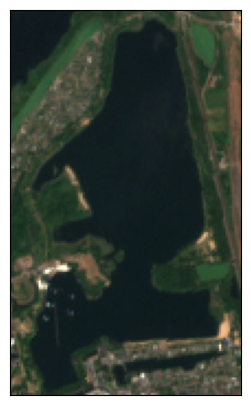

In [22]:
# verify that this is the area of interest
test_img = plot_test_image(bbox=bbox,
                           size=size,
                           config=config,
                           data_collection=DataCollection.SENTINEL2_L2A,
                           time_interval=("2019-06-01", "2023-06-30"),
                           max_cloud_coverage=0.05)

In [23]:
# get the wms request to obtain dates with available images
wms_request = get_wms_request(bbox=bbox,
                              time_frame=time_frame,
                              width=size[0],
                              config=config,
                              image_format=MimeType.TIFF,
                              time_difference=datetime.timedelta(hours=4),
                              data_collection=DataCollection.SENTINEL2_L2A,
                              layer='TRUE-COLOR-S2L2A')
# obtain the dates
img_dates = wms_request.get_dates()

print(f'Number of images available: {len(img_dates)}')
for dt in img_dates[:5]:
    print(f'{dt.date()}T00:00:00+01:00', f'{dt.date()}T23:59:59+01:00')

Number of images available: 958
2016-11-01T00:00:00+01:00 2016-11-01T23:59:59+01:00
2016-11-08T00:00:00+01:00 2016-11-08T23:59:59+01:00
2016-11-11T00:00:00+01:00 2016-11-11T23:59:59+01:00
2016-11-18T00:00:00+01:00 2016-11-18T23:59:59+01:00
2016-11-21T00:00:00+01:00 2016-11-21T23:59:59+01:00


In [24]:
# download all images from time frame
download_all_images(data_dir=data_dir,
                    img_dates=img_dates,
                    eval_script=evalscript_all_bands,
                    bbox=bbox,
                    bbox_size=size,
                    config=config,
                    data_collection=DataCollection.SENTINEL2_L2A,
                    mime_type=MimeType.TIFF)

Starting image download...
Finished.


---

### Download 39: Barleber See II (ST)

In [26]:
# define the bounding box corner coordinates (lower left, upper right) in WGS84
coords = (11.659627,52.215035,11.673789,52.226262)

# define resolution in m
resolution = 10

# define timeframe
time_frame = ["2014-01-01", "2023-11-28"]

# define a path where to download the images
data_dir = './../data/39_ST_barleber_see_ii/39_ST_barleber_see_ii_raw'
assert os.path.exists(data_dir), 'Path does not exist'

In [27]:
# Get bbox and bbox size
bbox, size = get_bbox_and_size(coords=coords, resolution=resolution, crs=CRS.WGS84)
print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 10 m resolution: (92, 128) pixels


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (128, 92, 3)
Image type: uint8


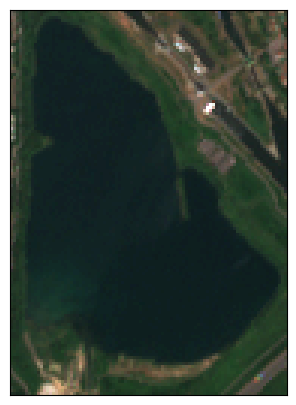

In [28]:
# verify that this is the area of interest
test_img = plot_test_image(bbox=bbox,
                           size=size,
                           config=config,
                           data_collection=DataCollection.SENTINEL2_L2A,
                           time_interval=("2019-06-01", "2023-06-30"),
                           max_cloud_coverage=0.05)

In [29]:
# get the wms request to obtain dates with available images
wms_request = get_wms_request(bbox=bbox,
                              time_frame=time_frame,
                              width=size[0],
                              config=config,
                              image_format=MimeType.TIFF,
                              time_difference=datetime.timedelta(hours=4),
                              data_collection=DataCollection.SENTINEL2_L2A,
                              layer='TRUE-COLOR-S2L2A')
# obtain the dates
img_dates = wms_request.get_dates()

print(f'Number of images available: {len(img_dates)}')
for dt in img_dates[:5]:
    print(f'{dt.date()}T00:00:00+01:00', f'{dt.date()}T23:59:59+01:00')

Number of images available: 958
2016-11-01T00:00:00+01:00 2016-11-01T23:59:59+01:00
2016-11-08T00:00:00+01:00 2016-11-08T23:59:59+01:00
2016-11-11T00:00:00+01:00 2016-11-11T23:59:59+01:00
2016-11-18T00:00:00+01:00 2016-11-18T23:59:59+01:00
2016-11-21T00:00:00+01:00 2016-11-21T23:59:59+01:00


In [30]:
# download all images from time frame
download_all_images(data_dir=data_dir,
                    img_dates=img_dates,
                    eval_script=evalscript_all_bands,
                    bbox=bbox,
                    bbox_size=size,
                    config=config,
                    data_collection=DataCollection.SENTINEL2_L2A,
                    mime_type=MimeType.TIFF)

Starting image download...
Finished.


---

### Download 40: Werratalsee (HE)

In [31]:
# define the bounding box corner coordinates (lower left, upper right) in WGS84
coords = (10.061696,51.187924,10.094869,51.198440)

# define resolution in m
resolution = 10

# define timeframe
time_frame = ["2014-01-01", "2023-11-28"]

# define a path where to download the images
data_dir = './../data/40_HE_werratalsee/40_HE_werratalsee_raw'
assert os.path.exists(data_dir), 'Path does not exist'

In [32]:
# Get bbox and bbox size
bbox, size = get_bbox_and_size(coords=coords, resolution=resolution, crs=CRS.WGS84)
print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 10 m resolution: (230, 120) pixels


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (120, 230, 3)
Image type: uint8


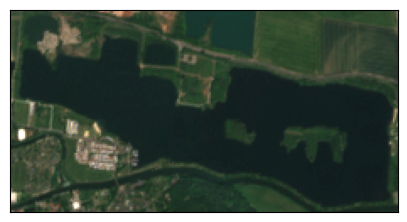

In [33]:
# verify that this is the area of interest
test_img = plot_test_image(bbox=bbox,
                           size=size,
                           config=config,
                           data_collection=DataCollection.SENTINEL2_L2A,
                           time_interval=("2019-06-01", "2023-06-30"),
                           max_cloud_coverage=0.05)

In [34]:
# get the wms request to obtain dates with available images
wms_request = get_wms_request(bbox=bbox,
                              time_frame=time_frame,
                              width=size[0],
                              config=config,
                              image_format=MimeType.TIFF,
                              time_difference=datetime.timedelta(hours=4),
                              data_collection=DataCollection.SENTINEL2_L2A,
                              layer='TRUE-COLOR-S2L2A')
# obtain the dates
img_dates = wms_request.get_dates()

print(f'Number of images available: {len(img_dates)}')
for dt in img_dates[:5]:
    print(f'{dt.date()}T00:00:00+01:00', f'{dt.date()}T23:59:59+01:00')

Number of images available: 954
2016-11-01T00:00:00+01:00 2016-11-01T23:59:59+01:00
2016-11-08T00:00:00+01:00 2016-11-08T23:59:59+01:00
2016-11-11T00:00:00+01:00 2016-11-11T23:59:59+01:00
2016-11-18T00:00:00+01:00 2016-11-18T23:59:59+01:00
2016-11-21T00:00:00+01:00 2016-11-21T23:59:59+01:00


In [ ]:
# download all images from time frame
download_all_images(data_dir=data_dir,
                    img_dates=img_dates,
                    eval_script=evalscript_all_bands,
                    bbox=bbox,
                    bbox_size=size,
                    config=config,
                    data_collection=DataCollection.SENTINEL2_L2A,
                    mime_type=MimeType.TIFF)

Starting image download...
